# Simulating Complex Physics with Graph Networks: step by step

## Overview

By Peng Chen, Shiyu Li, and Haochen Shi as part of the Stanford CS224W course project. This tutorial provides a step-by-step guide for how to build a Graph Network to simulate complex physics.

**Before we get started:**
- This Colab includes a concise PyG implementation of the paper ***Learning to Simulate Complex Physics with Graph Networks*. We adapted our code from the open-source tensorflow implementation by DeepMind.
    - Link to the pdf of this paper: https://arxiv.org/abs/2002.09405
    - Link to Deepmind's implementation: https://github.com/deepmind/deepmind-research/tree/master/learning_to_simulate
    - Link to the video site by DeepMind: https://sites.google.com/view/learning-to-simulate
- Make sure to **sequentially run all the cells in each section**, so that the intermediate variables / packages will carry over to the next cell.
- Feel free to make a copy to your own drive to play around with it! Have fun with this tutorial!

## Device

We recommend using a GPU for this Colab. Please click `Runtime` and then `Change runtime type`. Then set the `hardware accelerator` to **GPU**.

## Setup

The installation of PyG on Colab can be a little bit tricky. Before we get started, let's check which version of PyTorch you are running.

In [1]:
# Dataset Source #1:
# https://drive.google.com/file/d/1ZmiKpsQVLFxPOIff-LfFkZwe5ZYG1FEb/view?usp=drive_link

# Dataset Source #2:
# https://drive.google.com/drive/mobile/folders/11uuYl0peqPg2DQno64YPYMODPu8fjDXU?usp=sharing

In [2]:
#!pip install torch

In [2]:
import os
import torch
print(f"PyTorch has version {torch.__version__} with cuda {torch.version.cuda}")

PyTorch has version 1.12.1+cu102 with cuda 10.2



Download the necessary packages for PyG. Make sure that your version of torch matches the output from the cell above. In case of any issues, more information can be found on [PyG's installation page](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html)

In [4]:
!pip3 install torch==1.12.1+cu102 torchvision==0.13.1+cu102 torchaudio==0.12.1 torchtext --extra-index-url https://download.pytorch.org/whl/cu102
!pip install https://data.pyg.org/whl/torch-1.12.0%2Bcu102/torch_cluster-1.6.0%2Bpt112cu102-cp37-cp37m-linux_x86_64.whl
!pip install https://data.pyg.org/whl/torch-1.12.0%2Bcu102/torch_scatter-2.1.0%2Bpt112cu102-cp37-cp37m-linux_x86_64.whl
!pip install https://data.pyg.org/whl/torch-1.12.0%2Bcu102/torch_sparse-0.6.16%2Bpt112cu102-cp37-cp37m-linux_x86_64.whl
!pip install torch-geometric
!pip install matplotlib
!pip install networkx

# Dataset Preparation
!cd /home/admin1/Desktop/gnndataset/datasets/WaterDrop/

# metadata.json
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1o6cKxgbnfUUFPTX1JngBzB928w2bUIwk' -O metadata.json

# test_offset.json
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1vr4JiVliKCQNWVV4kziyusxNVUvQuAYL' -O test_offset.json

# test_particle_type.dat
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Z_r9ivdKqKZzVJG80gb2uY6JDVRd0wAt' -O test_particle_type.dat

# test_position.dat
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1wCeBz1pZ5hxmlqWw4eylajg6pzFgQjIJ' -O test_position.dat

# train_offset.json
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=160wnp9PEc1HuzsBi7kO0ryMu3tnon2tI' -O train_offset.json

# train_particle_type.dat
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1LVtGLld7assF4sPk0mF2Bz2F7FBaxU0O' -O train_particle_type.dat

# train_position.dat
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1YCXcir_fmJZLvXkbPjchsrr8VuuWugH0' -O train_position.dat

# valid_offset.json
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1tiDP5uHMJQDTNxyRNSb6sEZCWAADPu8a' -O valid_offset.json

# valid_particle_type.dat
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1fXIw9RWM0xzfK2sGn1H0DaAOxzm59ZEd' -O valid_particle_type.dat

# valid_position.dat
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1U9QuV3Ra0E1tDD1HgXYCYyn4SeLKXQGs' -O valid_position.dat


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu102
  Using cached https://data.pyg.org/whl/torch-1.12.0%2Bcu102/torch_cluster-1.6.0%2Bpt112cu102-cp37-cp37m-linux_x86_64.whl (1.4 MB)
  Using cached https://data.pyg.org/whl/torch-1.12.0%2Bcu102/torch_scatter-2.1.0%2Bpt112cu102-cp37-cp37m-linux_x86_64.whl (9.1 MB)
  Using cached https://data.pyg.org/whl/torch-1.12.0%2Bcu102/torch_sparse-0.6.16%2Bpt112cu102-cp37-cp37m-linux_x86_64.whl (2.9 MB)
--2024-07-24 00:37:24--  https://docs.google.com/uc?export=download&id=1o6cKxgbnfUUFPTX1JngBzB928w2bUIwk
Resolving docs.google.com (docs.google.com)... 172.253.118.101, 172.253.118.102, 172.253.118.138, ...
Connecting to docs.google.com (docs.google.com)|172.253.118.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1o6cKxgbnfUUFPTX1JngBzB928w2bUIwk&export=download [following]
--2024-07-24 00:37:25--  https://drive.usercontent.google.

HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1vr4JiVliKCQNWVV4kziyusxNVUvQuAYL&export=download [following]
--2024-07-24 00:37:27--  https://drive.usercontent.google.com/download?id=1vr4JiVliKCQNWVV4kziyusxNVUvQuAYL&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.175.132, 2404:6800:4003:c1a::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.175.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1061 (1.0K) [application/octet-stream]
Saving to: ‘test_offset.json’

test_offset.json    100%[===================>]   1.04K  --.-KB/s    in 0s      

2024-07-24 00:37:29 (25.1 MB/s) - ‘test_offset.json’ saved [1061/1061]

--2024-07-24 00:37:30--  https://docs.google.com/uc?export=download&id=1Z_r9ivdKqKZzVJG80gb2uY6JDVRd0wAt
Resolving docs.google.com (docs.google.com)... 172.253.118.100, 172.253.118.113, 172.253.118.139

HTTP request sent, awaiting response... 200 OK
Length: 20968 (20K) [application/octet-stream]
Saving to: ‘valid_particle_type.dat’

valid_particle_type 100%[===================>]  20.48K  --.-KB/s    in 0.005s  

2024-07-24 00:37:50 (4.40 MB/s) - ‘valid_particle_type.dat’ saved [20968/20968]

--2024-07-24 00:37:50--  https://docs.google.com/uc?export=download&id=1U9QuV3Ra0E1tDD1HgXYCYyn4SeLKXQGs
Resolving docs.google.com (docs.google.com)... 172.253.118.100, 172.253.118.113, 172.253.118.139, ...
Connecting to docs.google.com (docs.google.com)|172.253.118.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1U9QuV3Ra0E1tDD1HgXYCYyn4SeLKXQGs&export=download [following]
--2024-07-24 00:37:50--  https://drive.usercontent.google.com/download?id=1U9QuV3Ra0E1tDD1HgXYCYyn4SeLKXQGs&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.175.132, 2404:6800:4003:c1a::84
Conn

## Dataset

The dataset WaterDropSmall includes 100 videos of dropping water to the ground rendered in a particle-based physics simulator. It is a cropped version of the WaterDrop dataset by Deepmind. We will download this dataset from Google Cloud stoarge to the folder `temp/datasets` in the file system. You can inspect the downloaded files on the **Files** menu on the left of this Colab.

The `metadata.json` file in the dataset includes the following information:
1. The sequence length of each video data point
2. The dimensionality, 2d or 3d
3. The box bounds, which specify the bounding box for the scene
4. The default connectivity radius, which defines the size of each particle's neighborhood
5. The statistics for normalization, such as the mean and standard deviation of the velocity and acceleration of particles


Each data point in the dataset includes the following information:
1. The type of the particles, such as water
2. The particle positions at each frame in the video

In [3]:
DATASET_NAME = "WaterDrop"
OUTPUT_DIR = os.path.join("/home/admin1/Desktop/gnndataset/datasets/WaterDrop")

print("##################")
print("## DATASET_NAME ##")
print("##################")
print(DATASET_NAME)
print("")

print("################")
print("## OUTPUT_DIR ##")
print("################")
print(OUTPUT_DIR)
print("")

# BASE_URL = f"https://storage.googleapis.com/cs224w_course_project_dataset/{DATASET_NAME}"

# !mkdir -p "$OUTPUT_DIR"

# META_DATA_PATH = f"{OUTPUT_DIR}/metadata.json"
# CLOUD_PATH = f"{BASE_URL}/metadata.json"
# !wget -O "$META_DATA_PATH" "$CLOUD_PATH"
# for split in ["test", "train", "valid"]:
#   for suffix in ["offset.json", "particle_type.dat", "position.dat"]:
#       DATA_PATH = f"{OUTPUT_DIR}/{split}_{suffix}"
#       CLOUD_PATH = f"{BASE_URL}/{split}_{suffix}"
#       !wget -O "$DATA_PATH" "$CLOUD_PATH"

##################
## DATASET_NAME ##
##################
WaterDrop

################
## OUTPUT_DIR ##
################
/home/admin1/Desktop/gnndataset/datasets/WaterDrop



## Data Preprocessing

• Since cannot apply raw data in dataset to train GNN model directly, must go through following steps to convert raw data into graphs with descriptive node features and edge features:
1. Apply noise to trajectory to have more diverse training examples
1. Construct graph based on distance between particles
1. Extract node-level features: particle velocities and their distance to boundary
1. Extract edge-level features: displacement and distance between particles

• If you are not interested in data pipeline, your can skip to end of this section. 
• There is a detailed explanation and visualization of one data point.

In [4]:
!export LD_LIBRARY_PATH=/home/admin1/anaconda3/envs/GNN/lib:$LD_LIBRARY_PATH
    

In [13]:
import json
import numpy as np
import torch_geometric as pyg

def generate_noise(position_seq, noise_std):
    """Generate noise for a trajectory"""
    velocity_seq = position_seq[:, 1:] - position_seq[:, :-1]
    print("####################################")
    print("## velocity_seq ## generate_noise ##")
    print("####################################")
    print(velocity_seq)
    print("")


    time_steps = velocity_seq.size(1)
    print("##################################")
    print("## time_steps ## generate_noise ##")
    print("##################################")
    print(time_steps)
    print("")
    
    velocity_noise = torch.randn_like(velocity_seq) * (noise_std / time_steps ** 0.5)
    print("######################################")
    print("## velocity_noise ## generate_noise ##")
    print("######################################")
    print(velocity_noise)
    print("")
    
    velocity_noise = velocity_noise.cumsum(dim=1)
    print("######################################")
    print("## velocity_noise ## generate_noise ##")
    print("######################################")
    print(velocity_noise)
    print("")
    
    
    position_noise = velocity_noise.cumsum(dim=1)
    print("######################################")
    print("## position_noise ## generate_noise ##")
    print("######################################")
    print(position_noise)
    print("")
    
    
    position_noise = torch.cat((torch.zeros_like(position_noise)[:, 0:1], position_noise), dim=1)
    print("######################################")
    print("## position_noise ## generate_noise ##")
    print("######################################")
    print(position_noise)
    print("")
    
    
    return position_noise


def preprocess(particle_type, position_seq, target_position, metadata, noise_std):
    """Preprocess a trajectory and construct the graph"""
    # apply noise to the trajectory
    position_noise = generate_noise(position_seq, noise_std)
    print("##################################")
    print("## position_noise ## preprocess ##")
    print("##################################")
    print(position_noise)
    print("")
    
    
    position_seq = position_seq + position_noise
    print("################################")
    print("## position_seq ## preprocess ##")
    print("################################")
    print(position_seq)
    print("")
    

    # calculate the velocities of particles
    recent_position = position_seq[:, -1]
    print("###################################")
    print("## recent_position ## preprocess ##")
    print("###################################")
    print(recent_position)
    print("")
    
    
    velocity_seq = position_seq[:, 1:] - position_seq[:, :-1]
    print("################################")
    print("## velocity_seq ## preprocess ##")
    print("################################")
    print(velocity_seq)
    print("")
    
    
    # construct the graph based on the distances between particles
    n_particle = recent_position.size(0)
    print("##############################")
    print("## n_particle ## preprocess ##")
    print("##############################")
    print(n_particle)
    print("")
    
    
    edge_index = pyg.nn.radius_graph(recent_position, metadata["default_connectivity_radius"], loop=True, max_num_neighbors=n_particle)
    print("##############################")
    print("## edge_index ## preprocess ##")
    print("##############################")
    print(edge_index)
    print("")

    
    # node-level features: velocity, distance to the boundary
    normal_velocity_seq = (velocity_seq - torch.tensor(metadata["vel_mean"])) / torch.sqrt(torch.tensor(metadata["vel_std"]) ** 2 + noise_std ** 2)
    print("#######################################")
    print("## normal_velocity_seq ## preprocess ##")
    print("#######################################")
    print(normal_velocity_seq)
    print("")
    
    
    boundary = torch.tensor(metadata["bounds"])
    print("############################")
    print("## boundary ## preprocess ##")
    print("############################")
    print(boundary)
    print("")
    
    
    distance_to_lower_boundary = recent_position - boundary[:, 0]
    print("##############################################")
    print("## distance_to_lower_boundary ## preprocess ##")
    print("##############################################")
    print("Shape:", distance_to_lower_boundary.shape)
    print("Length:", len(distance_to_lower_boundary))
    print("Type:", type(distance_to_lower_boundary))
    print(distance_to_lower_boundary)
    print("")
    
    
    distance_to_upper_boundary = boundary[:, 1] - recent_position
    print("##############################################")
    print("## distance_to_upper_boundary ## preprocess ##")
    print("##############################################")
    print("Shape:", distance_to_upper_boundary.shape)
    print("Length:", len(distance_to_upper_boundary))
    print("Type:", type(distance_to_upper_boundary))
    print(distance_to_upper_boundary)
    print("")
    
    
    distance_to_boundary = torch.cat((distance_to_lower_boundary, distance_to_upper_boundary), dim=-1)
    print("########################################")
    print("## distance_to_boundary ## preprocess ##")
    print("########################################")
    print("Shape:", distance_to_boundary.shape)
    print("Length:", len(distance_to_boundary))
    print("Type:", type(distance_to_boundary))
    print(distance_to_boundary)
    print("")
    
    
    distance_to_boundary = torch.clip(distance_to_boundary / metadata["default_connectivity_radius"], -1.0, 1.0)
    print("########################################")
    print("## distance_to_boundary ## preprocess ##")
    print("########################################")
    print("Shape:", distance_to_boundary.shape)
    print("Length:", len(distance_to_boundary))
    print("Type:", type(distance_to_boundary))
    print(distance_to_boundary)
    print("")
    
    

    # edge-level features: displacement, distance
    dim = recent_position.size(-1)
    print("#######################")
    print("## dim ## preprocess ##")
    print("#######################")
    # print("Shape:", dim.shape)
    # print("Length:", len(dim))
    print("Type:", type(dim))
    print(dim)
    print("")
    
    
    edge_displacement = (torch.gather(recent_position, dim=0, index=edge_index[0].unsqueeze(-1).expand(-1, dim)) -
                   torch.gather(recent_position, dim=0, index=edge_index[1].unsqueeze(-1).expand(-1, dim)))
    print("#####################################")
    print("## edge_displacement ## preprocess ##")
    print("#####################################")
    print("Shape:", edge_displacement.shape)
    print("Length:", len(edge_displacement))
    print("Type:", type(edge_displacement))
    print(edge_displacement)
    print("")
    
    
    edge_displacement /= metadata["default_connectivity_radius"]
    print("#####################################")
    print("## edge_displacement ## preprocess ##")
    print("#####################################")
    print("Shape:", edge_displacement.shape)
    print("Length:", len(edge_displacement))
    print("Type:", type(edge_displacement))
    print(edge_displacement)
    print("")
    
    
    edge_distance = torch.norm(edge_displacement, dim=-1, keepdim=True)
    print("#################################")
    print("## edge_distance ## preprocess ##")
    print("#################################")
    print("Shape:", edge_distance.shape)
    print("Length:", len(edge_distance))
    print("Type:", type(edge_distance))
    print(edge_distance)
    print("")

    
    # ground truth for training
    if target_position is not None:
        last_velocity = velocity_seq[:, -1]
        print("#################################")
        print("## last_velocity ## preprocess ##")
        print("#################################")
        print("Shape:", last_velocity.shape)
        print("Length:", len(last_velocity))
        print("Type:", type(last_velocity))
        print(last_velocity)
        print("")
        
        
        next_velocity = target_position + position_noise[:, -1] - recent_position
        print("#################################")
        print("## next_velocity ## preprocess ##")
        print("#################################")
        print("Shape:", next_velocity.shape)
        print("Length:", len(next_velocity))
        print("Type:", type(next_velocity))
        print(next_velocity)
        print("")
        
        
        acceleration = next_velocity - last_velocity
        print("################################")
        print("## acceleration ## preprocess ##")
        print("################################")
        print("Shape:", acceleration.shape)
        print("Length:", len(acceleration))
        print("Type:", type(acceleration))
        print(acceleration)
        print("")
        
        
        acceleration = (acceleration - torch.tensor(metadata["acc_mean"])) / torch.sqrt(torch.tensor(metadata["acc_std"]) ** 2 + noise_std ** 2)
        print("################################")
        print("## acceleration ## preprocess ##")
        print("################################")
        print("Shape:", acceleration.shape)
        print("Length:", len(acceleration))
        print("Type:", type(acceleration))
        print(acceleration)
        print("")
        
        
        
    else:
        acceleration = None

    # return the graph with features
    graph = pyg.data.Data(
        x=particle_type,
        edge_index=edge_index,
        edge_attr=torch.cat((edge_displacement, edge_distance), dim=-1),
        y=acceleration,
        pos=torch.cat((velocity_seq.reshape(velocity_seq.size(0), -1), distance_to_boundary), dim=-1)
    )
    return graph

### One Step Dataset

• Each datapoint in this dataset contains trajectories sliced to short time windows. 

• will use this dataset in training phase because history of particles' states are necessary for model to make predictions. 

• But in meantime, since long-horizon prediction is inaccurate and time-consuming, sliced trajectories to short time windows to improve perfomance of model.

In [14]:
class OneStepDataset(pyg.data.Dataset):
    def __init__(self, data_path, split, window_length=7, noise_std=0.0, return_pos=False):
        super().__init__()

        print("#################################")
        print("## data_path ## OneStepDataset ##")
        print("#################################")
        print(data_path)
        print("")

        
        # load dataset from the disk
        with open(os.path.join(data_path, "metadata.json")) as f:
            self.metadata = json.load(f)
            print("#####################################")
            print("## self.metadata ## OneStepDataset ##")
            print("#####################################")
            # print("Shape:", self.metadata.shape)
            print("Length:", len(self.metadata))
            print("Type:", type(self.metadata))
            print(self.metadata)
            print("")
            
            
        with open(os.path.join(data_path, f"{split}_offset.json")) as f:
            self.offset = json.load(f)
            print("###################################")
            print("## self.offset ## OneStepDataset ## 1")
            print("###################################")
            # print("Shape:", self.offset.shape)
            print("Length:", len(self.offset))
            print("Type:", type(self.offset))
            print(self.offset)
            print("")
            
            
        self.offset = {int(k): v for k, v in self.offset.items()}
        print("###################################")
        print("## self.offset ## OneStepDataset ## 2")
        print("###################################")
        #print("Shape:", self.offset.shape)
        print("Length:", len(self.offset))
        print("Type:", type(self.offset))
        print(self.offset)
        print("")
        
        
        self.window_length = window_length
        print("#####################################")
        print("## window_length ## OneStepDataset ##")
        print("#####################################")
        # print("Shape:", window_length.shape)
        # print("Length:", len(window_length))
        print("Type:", type(window_length))
        print(window_length)
        print("")
        
        
        self.noise_std = noise_std
        print("#################################")
        print("## noise_std ## OneStepDataset ##")
        print("#################################")
        # print("Shape:", noise_std.shape)
        # print("Length:", len(noise_std))
        print("Type:", type(noise_std))
        print(noise_std)
        print("")
        
        
        self.return_pos = return_pos
        print("##################################")
        print("## return_pos ## OneStepDataset ##")
        print("##################################")
        # print("Shape:", return_pos.shape)
        # print("Length:", len(return_pos))
        print("Type:", type(return_pos))
        print(return_pos)
        print("")
        

        self.particle_type = np.memmap(os.path.join(data_path, f"{split}_particle_type.dat"), dtype=np.int64, mode="r")
        print("##########################################")
        print("## self.particle_type ## OneStepDataset ##")
        print("##########################################")
        print("Shape:", self.particle_type.shape)
        print("Length:", len(self.particle_type))
        print("Type:", type(self.particle_type))
        print(self.particle_type)
        print("")
        
        
        self.position = np.memmap(os.path.join(data_path, f"{split}_position.dat"), dtype=np.float32, mode="r")
        print("#####################################")
        print("## self.position ## OneStepDataset ##")
        print("#####################################")
        print("Shape:", self.position.shape)
        print("Length:", len(self.position))
        print("Type:", type(self.position))
        print(self.position)
        print("")

        for traj in self.offset.values():
            self.dim = traj["position"]["shape"][2]
            print("################################")
            print("## self.dim ## OneStepDataset ##")
            print("################################")
            # print("Shape:", self.dim.shape)
            # print("Length:", len(self.dim))
            print("Type:", type(self.dim))
            print(self.dim)
            print("")
            
            break

        # cut particle trajectories according to time slices
        self.windows = []
        for traj in self.offset.values():
            size = traj["position"]["shape"][1]
            print("############################")
            print("## size ## OneStepDataset ##")
            print("############################")
            # print("Shape:", size.shape)
            # print("Length:", len(size))
            print("Type:", type(size))
            print(size)
            print("")
            
            
            length = traj["position"]["shape"][0] - window_length + 1
            print("############")
            print("## length ## OneStepDataset ##")
            print("############")
            # print("Shape:", length.shape)
            # print("Length:", len(length))
            print("Type:", type(length))
            print(length)
            print("")
            
            
            
            for i in range(length):
                desc = {
                    "size": size,
                    "type": traj["particle_type"]["offset"],
                    "pos": traj["position"]["offset"] + i * size * self.dim,
                }
                self.windows.append(desc)

    def len(self):
        return len(self.windows)

    def get(self, idx):
        # load corresponding data for this time slice
        window = self.windows[idx]
        print("###################")
        print("## window ## get ##")
        print("###################")
        # print("Shape:", window.shape)
        print("Length:", len(window))
        print("Type:", type(window))
        print(window)
        print("")
        
        
        size = window["size"]
        print("#################")
        print("## size ## get ##")
        print("#################")
        # print("Shape:", size.shape)
        # print("Length:", len(size))
        print("Type:", type(size))
        print(size)
        print("")
        
        
        particle_type = self.particle_type[window["type"]: window["type"] + size].copy()
        print("##########################")
        print("## particle_type ## get ##")
        print("##########################")
        print("Shape:", particle_type.shape)
        print("Length:", len(particle_type))
        print("Type:", type(particle_type))
        print(particle_type)
        print("")
        
        
        particle_type = torch.from_numpy(particle_type)
        print("##########################")
        print("## particle_type ## get ##")
        print("##########################")
        print("Shape:", particle_type.shape)
        print("Length:", len(particle_type))
        print("Type:", type(particle_type))
        print(particle_type)
        print("")
        
        
        position_seq = self.position[window["pos"]: window["pos"] + self.window_length * size * self.dim].copy()
        print("#########################")
        print("## position_seq ## get ##")
        print("#########################")
        print("Shape:", position_seq.shape)
        print("Length:", len(position_seq))
        print("Type:", type(position_seq))
        print(position_seq)
        print("")        
        
        position_seq.resize(self.window_length, size, self.dim)
        print("#########################")
        print("## position_seq ## get ##")
        print("#########################")
        print("Shape:", position_seq.shape)
        print("Length:", len(position_seq))
        print("Type:", type(position_seq))
        print(position_seq)
        print("")        
        
        position_seq = position_seq.transpose(1, 0, 2)
        print("#########################")
        print("## position_seq ## get ##")
        print("#########################")
        print("Shape:", position_seq.shape)
        print("Length:", len(position_seq))
        print("Type:", type(position_seq))
        print(position_seq)
        print("")        
        
        target_position = position_seq[:, -1]
        print("############################")
        print("## target_position ## get ##")
        print("############################")
        print("Shape:", target_position.shape)
        print("Length:", len(target_position))
        print("Type:", type(target_position))
        print(target_position)
        print("")
        
        
        position_seq = position_seq[:, :-1]
        print("#########################")
        print("## position_seq ## get ##")
        print("#########################")
        print("Shape:", position_seq.shape)
        print("Length:", len(position_seq))
        print("Type:", type(position_seq))
        print(position_seq)
        print("")        
        
        target_position = torch.from_numpy(target_position)
        print("############################")
        print("## target_position ## get ##")
        print("############################")
        print("Shape:", target_position.shape)
        print("Length:", len(target_position))
        print("Type:", type(target_position))
        print(target_position)
        print("")
        
        
        position_seq = torch.from_numpy(position_seq)
        print("#########################")
        print("## position_seq ## get ##")
        print("#########################")
        print("Shape:", position_seq.shape)
        print("Length:", len(position_seq))
        print("Type:", type(position_seq))
        print(position_seq)
        print("")

        # construct the graph
        with torch.no_grad():
            graph = preprocess(particle_type, position_seq, target_position, self.metadata, self.noise_std)
        if self.return_pos:
          return graph, position_seq[:, -1]
        return graph

### Rollout Dataset

• Each datapoint in this dataset contains trajectories of particles over 1000 time frames. 

• This dataset used in evaluation phase to measure model's ability to make long-horizon predictions.

In [48]:
class RolloutDataset(pyg.data.Dataset):
    def __init__(self, data_path, split, window_length=7):
        super().__init__()

        # load data from the disk
        with open(os.path.join(data_path, "metadata.json")) as f:
            self.metadata = json.load(f)
            print("############################################")
            print("## self.metadata ## RolloutDataset\_init_ ##")
            print("############################################")
            # print("Shape:", self.metadata.shape)
            print("Length:", len(self.metadata))
            print("Type:", type(self.metadata))
            print(self.metadata)
            print("")
            
            
        with open(os.path.join(data_path, f"{split}_offset.json")) as f:
            self.offset = json.load(f)
            print("##########################################")
            print("## self.offset ## RolloutDataset\_init_ ##")
            print("##########################################")
            # print("Shape:", self.offset.shape)
            print("Length:", len(self.offset))
            print("Type:", type(self.offset))
            print(self.offset)
            print("")
            
            
        self.offset = {int(k): v for k, v in self.offset.items()}
        print("##########################################")
        print("## self.offset ## RolloutDataset\_init_ ##")
        print("##########################################")
        # print("Shape:", self.offset.shape)
        print("Length:", len(self.offset))
        print("Type:", type(self.offset))
        print(self.offset)
        print("")
        
        
        self.window_length = window_length
        print("############################################")
        print("## window_length ## RolloutDataset\_init_ ##")
        print("############################################")
        # print("Shape:", window_length.shape)
        # print("Length:", len(window_length))
        print("Type:", type(window_length))
        print(window_length)
        print("")
        

        self.particle_type = np.memmap(os.path.join(data_path, f"{split}_particle_type.dat"), dtype=np.int64, mode="r")
        print("#################################################")
        print("## self.particle_type ## RolloutDataset\_init_ ##")
        print("#################################################")
        print("Shape:", self.particle_type.shape)
        print("Length:", len(self.particle_type))
        print("Type:", type(self.particle_type))
        print(self.particle_type)
        print("")
        
        
        self.position = np.memmap(os.path.join(data_path, f"{split}_position.dat"), dtype=np.float32, mode="r")
        print("############################################")
        print("## self.position ## RolloutDataset\_init_ ##")
        print("############################################")
        print("Shape:", self.position.shape)
        print("Length:", len(self.position))
        print("Type:", type(self.position))
        print(self.position)
        print("")

        
        for traj in self.offset.values():
            self.dim = traj["position"]["shape"][2]
            break

    def len(self):
        return len(self.offset)

    def get(self, idx):
        traj = self.offset[idx]
        print("################################")
        print("## traj ## RolloutDataset\get ##")
        print("################################")
        print("Shape:", traj.shape)
        print("Length:", len(traj))
        print("Type:", type(traj))
        print(traj)
        print("")
        
        
        size = traj["position"]["shape"][1]
        print("################################")
        print("## size ## RolloutDataset\get ##")
        print("################################")
        # print("Shape:", size.shape)
        # print("Length:", len(size))
        print("Type:", type(size))
        print(size)
        print("")
        
        
        time_step = traj["position"]["shape"][0]
        print("#####################################")
        print("## time_step ## RolloutDataset\get ##")
        print("#####################################")
        print("Shape:", time_step.shape)
        print("Length:", len(time_step))
        print("Type:", type(time_step))
        print(time_step)
        print("")
        
        
        particle_type = self.particle_type[traj["particle_type"]["offset"]: traj["particle_type"]["offset"] + size].copy()
        print("#########################################")
        print("## particle_type ## RolloutDataset\get ##")
        print("#########################################")
        print("Shape:", particle_type.shape)
        print("Length:", len(particle_type))
        print("Type:", type(particle_type))
        print(particle_type)
        print("")
        
        
        particle_type = torch.from_numpy(particle_type)
        print("#########################################")
        print("## particle_type ## RolloutDataset\get ##")
        print("#########################################")
        print("Shape:", particle_type.shape)
        print("Length:", len(particle_type))
        print("Type:", type(particle_type))
        print(particle_type)
        print("")
        
        
        position = self.position[traj["position"]["offset"]: traj["position"]["offset"] + time_step * size * self.dim].copy()
        print("##############")
        print("## position ## RolloutDataset\get ##")
        print("##############")
        print("Shape:", position.shape)
        print("Length:", len(position))
        print("Type:", type(position))
        print(position)
        print("")
        
        
        position.resize(traj["position"]["shape"])
        print("####################################")
        print("## position ## RolloutDataset\get ##")
        print("####################################")
        print("Shape:", position.shape)
        print("Length:", len(position))
        print("Type:", type(position))
        print(position)
        print("")
        
        
        position = torch.from_numpy(position)
        print("####################################")
        print("## position ## RolloutDataset\get ##")
        print("####################################")
        print("Shape:", position.shape)
        print("Length:", len(position))
        print("Type:", type(position))
        print(position)
        print("")
        
        
        data = {"particle_type": particle_type, "position": position}
        print("################################")
        print("## data ## RolloutDataset\get ##")
        print("################################")
        print("Shape:", data.shape)
        print("Length:", len(data))
        print("Type:", type(data))
        print(data)
        print("")
        
        
        return data

### Visualize a graph in the dataset

Each data point in the dataset is a `pyg.data.Data` object which describes a graph. We explain the contents of the first data point, and visualize the graph.

#################################
## data_path ## OneStepDataset ##
#################################
/home/admin1/Desktop/gnndataset/datasets/WaterDrop

#####################################
## self.metadata ## OneStepDataset ##
#####################################
Length: 9
Type: <class 'dict'>
{'bounds': [[0.1, 0.9], [0.1, 0.9]], 'sequence_length': 1000, 'default_connectivity_radius': 0.015, 'dim': 2, 'dt': 0.0025, 'vel_mean': [-3.964619574176163e-05, -0.00026272129664401046], 'vel_std': [0.0013722809722366911, 0.0013119977252142715], 'acc_mean': [2.602686518497945e-08, 1.0721623948191945e-07], 'acc_std': [6.742962470925277e-05, 8.700719180424815e-05]}

###################################
## self.offset ## OneStepDataset ## 1
###################################
Length: 5
Type: <class 'dict'>
{'0': {'particle_type': {'offset': 0, 'shape': [482]}, 'position': {'offset': 0, 'shape': [1001, 482, 2]}}, '1': {'particle_type': {'offset': 482, 'shape': [362]}, 'position': {'offset': 964964

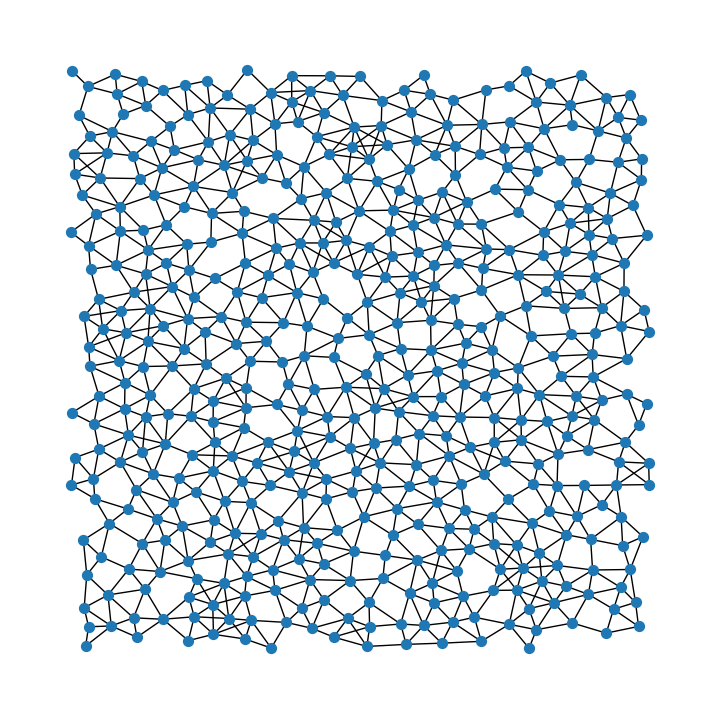

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx

dataset_sample = OneStepDataset(OUTPUT_DIR, "valid", return_pos=True)
print("####################")
print("## dataset_sample ##")
print("####################")
# print("Shape:", dataset_sample.shape)
print("Length:", len(dataset_sample))
print("Type:", type(dataset_sample))
print(dataset_sample)
print("")

graph, position = dataset_sample[0]
print("###########")
print("## graph ##")
print("###########")
# print("Shape:", graph.shape)
print("Length:", len(graph))
print("Type:", type(graph))
print(graph)
print("")

print("##############")
print("## position ##")
print("##############")
print("Shape:", position.shape)
print("Length:", len(position))
print("Type:", type(position))
print(position)
print("")

print(f"The first item in the valid set is a graph: {graph}")
print(f"This graph has {graph.num_nodes} nodes and {graph.num_edges} edges.")
print(f"Each node is a particle and each edge is the interaction between two particles.")
print(f"Each node has {graph.num_node_features} categorial feature (Data.x), which represents the type of the node.")
print(f"Each node has a {graph.pos.size(1)}-dim feature vector (Data.pos), which represents the positions and velocities of the particle (node) in several frames.")
print(f"Each edge has a {graph.num_edge_features}-dim feature vector (Data.edge_attr), which represents the relative distance and displacement between particles.")
print(f"The model is expected to predict a {graph.y.size(1)}-dim vector for each node (Data.y), which represents the acceleration of the particle.")

# remove directions of edges, because it is a symmetric directed graph.
nx_graph = pyg.utils.to_networkx(graph).to_undirected()
print("##############")
print("## nx_graph ##")
print("##############")
# print("Shape:", nx_graph.shape)
print("Length:", len(nx_graph))
print("Type:", type(nx_graph))
print(nx_graph)
print("")


# remove self loops, because every node has a self loop.
nx_graph.remove_edges_from(nx.selfloop_edges(nx_graph))
print("##############")
print("## nx_graph ##")
print("##############")
# print("Shape:", nx_graph.shape)
print("Length:", len(nx_graph))
print("Type:", type(nx_graph))
print(nx_graph)
print("")


plt.figure(figsize=(7, 7))


nx.draw(nx_graph, pos={i: tuple(v) for i, v in enumerate(position)}, node_size=50)


plt.show()

## GNN Model

We will walk through the implementation of the GNN model in this section!

### Helper class

We first define a class for Multi-Layer Perceptron (MLP). This class generates an MLP given the width and the depth of it. Because MLPs are used in several places of the GNN, this helper class will make the code cleaner.

In [84]:
import math
import torch_scatter

class MLP(torch.nn.Module):
    """Multi-Layer perceptron"""
    def __init__(self, input_size, hidden_size, output_size, layers, layernorm=True):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        print("###############################")
        print("## self.layers ## MLP\_init_ ##")
        print("###############################")
        # print("Shape:", self.layers.shape)
        print("Length:", len(self.layers))
        print("Type:", type(self.layers))
        print(self.layers)
        print("")
        
        for i in range(layers):
            self.layers.append(torch.nn.Linear(
                input_size if i == 0 else hidden_size,
                output_size if i == layers - 1 else hidden_size,
            ))
            
            
            if i != layers - 1:
                self.layers.append(torch.nn.ReLU())
                print("#################################")
                print("## self.layers ## MLP\_init_\i ##")
                print("#################################")
                # print("Shape:", self.layers.shape)
                print("Length:", len(self.layers))
                print("Type:", type(self.layers))
                print(self.layers)
                print("")
                
                
        if layernorm:
            self.layers.append(torch.nn.LayerNorm(output_size))
            print("########################")
            print("## self.layers ## MLP ##")
            print("########################")
            # print("Shape:", self.layers.shape)
            print("Length:", len(self.layers))
            print("Type:", type(self.layers))
            print(self.layers)
            print("")
            
            
        self.reset_parameters()

    def reset_parameters(self):
        
        
        for layer in self.layers:
            print("###################################")
            print("## layer ## MLP\reset_parameters ##")
            print("###################################")
            # print("Shape:", layer.shape)
            # print("Length:", len(layer))
            print("Type:", type(layer))
            print(layer)
            print("")
            
            if isinstance(layer, torch.nn.Linear):
                layer.weight.data.normal_(0, 1 / math.sqrt(layer.in_features))
                print("###################################")
                print("## layer ## MLP\reset_parameters ##")
                print("###################################")
                # print("Shape:", layer.shape)
                # print("Length:", len(layer))
                print("Type:", type(layer))
                print(layer)
                print("")
                
                
                layer.bias.data.fill_(0)
                print("###################################")
                print("## layer ## MLP\reset_parameters ##")
                print("###################################")
                # print("Shape:", layer.shape)
                # print("Length:", len(layer))
                print("Type:", type(layer))
                print(layer)
                print("")

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

### GNN layers

In the following code block, we implement one type of GNN layer named `InteractionNetwork` (IN), which is proposed by the paper *Interaction Networks for Learning about Objects,
Relations and Physics*.

For a graph $G$, let the feature of node $i$ be $v_i$, and the feature of edge $(i, j)$ be $e_{i, j}$. There are three stages for IN to generate new features of nodes and edges.

1. **Message generation.** If there is an edge pointing from node $i$ to node $j$, node $i$ sends a message to node $j$. The message carries the information of the edge and its two nodes, so it is generated by the following equation $\mathrm{Msg}_{i,j} = \mathrm{MLP}(v_i, v_j, e_{i,j})$.

1. **Message aggregation.** In this stage, each node of the graph aggregates all the messages that it received to a fixed-sized representation. In the IN, aggregation means summing all the messages up, i.e., $\mathrm{Agg}_i=\sum_{(j,i)\in G}\mathrm{Msg}_{i,j}$.

1. **Update.** Finally, we update features of nodes and edges with the results of previous stages. For each edge, its new feature is simply the sum of its old feature and the correspond message, i.e., $e'_{i,j}=e_{i,j}+\mathrm{Msg}_{i,j}$. For each node, the new feature is determined by its old feature and the aggregated message, i.e., $v'_i=v_i+\mathrm{MLP}(v_i, \mathrm{Agg}_i)$.

In PyG, GNN layers are implemented as subclass of `MessagePassing`. We need to override three critical functions to implement our `InteractionNetwork` GNN layer. Each function corresponds to one stage of the GNN layer.

1. `message()` -> message generation

  This function controls how a message is generated on each edge of the graph. It takes three arguments: (1) `x_i`, features of the source nodes; (2) `x_j`, features of the target nodes; and (3) `edge_feature`, features of the edges themselves. In the IN, we simply concatenate all these features and generate the messages with an MLP.

1. `aggregate()` -> message aggregation

  This function aggregates messages for nodes. It depends on two arguments: (1) `inputs`, messages; and (2) `index`, the graph structure. We handle over the task of message aggregation to the function `torch_scatter.scatter` and specifies in the argument `reduce` that we want to sum messages up. Because we want to retain messages themselves to update edge features, we return both messages and aggregated messages.

1. `forward()` -> update

  This function puts everything together. `x` is the node features, `edge_index` is the graph structure and `edge_feature` is edge features. The function`MessagePassing.propagate` invokes functions `message` and `aggregate` for us. Then, we update node features and edge features and return them.

In [85]:
class InteractionNetwork(pyg.nn.MessagePassing):
    """Interaction Network as proposed in this paper:
    https://proceedings.neurips.cc/paper/2016/hash/3147da8ab4a0437c15ef51a5cc7f2dc4-Abstract.html"""
    def __init__(self, hidden_size, layers):
        super().__init__()
        self.lin_edge = MLP(hidden_size * 3, hidden_size, hidden_size, layers)
        self.lin_node = MLP(hidden_size * 2, hidden_size, hidden_size, layers)

    def forward(self, x, edge_index, edge_feature):
        edge_out, aggr = self.propagate(edge_index, x=(x, x), edge_feature=edge_feature)
        print("############################################")
        print("## edge_out ## InteractionNetwork\forward ##")
        print("############################################")
        print("Shape:", edge_out.shape)
        print("Length:", len(edge_out))
        print("Type:", type(edge_out))
        print(edge_out)
        print("")
        
        
        node_out = self.lin_node(torch.cat((x, aggr), dim=-1))
        print("############################################")
        print("## node_out ## InteractionNetwork\forward ##")
        print("############################################")
        print("Shape:", node_out.shape)
        print("Length:", len(node_out))
        print("Type:", type(node_out))
        print(node_out)
        print("")
        
        
        edge_out = edge_feature + edge_out
        print("############################################")
        print("## edge_out ## InteractionNetwork\forward ##")
        print("############################################")
        print("Shape:", edge_out.shape)
        print("Length:", len(edge_out))
        print("Type:", type(edge_out))
        print(edge_out)
        print("")
        
        
        node_out = x + node_out
        print("############################################")
        print("## node_out ## InteractionNetwork\forward ##")
        print("############################################")
        print("Shape:", node_out.shape)
        print("Length:", len(node_out))
        print("Type:", type(node_out))
        print(node_out)
        print("")
        
        
        return node_out, edge_out

    def message(self, x_i, x_j, edge_feature):
        x = torch.cat((x_i, x_j, edge_feature), dim=-1)
        print("#####################################")
        print("## x ## InteractionNetwork\message ##")
        print("#####################################")
        print("Shape:", x.shape)
        print("Length:", len(x))
        print("Type:", type(x))
        print(x)
        print("")
        
        
        x = self.lin_edge(x)
        print("#####################################")
        print("## x ## InteractionNetwork\message ##")
        print("#####################################")
        print("Shape:", x.shape)
        print("Length:", len(x))
        print("Type:", type(x))
        print(x)
        print("")
        
        
        return x

    def aggregate(self, inputs, index, dim_size=None):
        out = torch_scatter.scatter(inputs, index, dim=self.node_dim, dim_size=dim_size, reduce="sum")
        print("#########################################")
        print("## out ## InteractionNetwork\aggregate ##")
        print("#########################################")
        print("Shape:", out.shape)
        print("Length:", len(out))
        print("Type:", type(out))
        print(out)
        print("")
        
        return (inputs, out)

### The GNN

Now its time to stack GNN layers to a GNN. Besides GNN layers, there are pre-processing and post-processing blocks in the GNN. Before GNN layers, input features are transformed by MLP so that the expressiveness of GNN is improved without increasing GNN layers. After GNN layers, final outputs (accelerations of particles in our case) are extracted from features generated by GNN layers to meet the requirement of the task.

In [127]:
class LearnedSimulator(torch.nn.Module):
    """Graph Network-based Simulators(GNS)"""
    def __init__(
        self,
        hidden_size=128,
        n_mp_layers=10, # number of GNN layers
        num_particle_types=9,
        particle_type_dim=16, # embedding dimension of particle types
        dim=2, # dimension of the world, typical 2D or 3D
        window_size=5, # the model looks into W frames before the frame to be predicted
    ):
        super().__init__()
        self.window_size = window_size
        print("############################################")
        print("## window_size ## LearnedSimulator\_init_ ##")
        print("############################################")
        print(window_size)
        print("")
        
        
        self.embed_type = torch.nn.Embedding(num_particle_types, particle_type_dim)
        print("#####################")
        print("## self.embed_type ## LearnedSimulator\_init_ ##")
        print("#####################")
        # print("Shape:", self.embed_type.shape)
        # print("Length:", len(self.embed_type))
        print("Type:", type(self.embed_type))
        print(self.embed_type)
        print("")
        
        
        self.node_in = MLP(particle_type_dim + dim * (window_size + 2), hidden_size, hidden_size, 3)
        print("#############################################")
        print("## self.node_in ## LearnedSimulator\_init_ ##")
        print("#############################################")
        # print("Shape:", self.node_in.shape)
        # print("Length:", len(self.node_in))
        print("Type:", type(self.node_in))
        print(self.node_in)
        print("")
        
        
        self.edge_in = MLP(dim + 1, hidden_size, hidden_size, 3)
        print("#############################################")
        print("## self.edge_in ## LearnedSimulator\_init_ ##")
        print("#############################################")
        # print("Shape:", self.edge_in.shape)
        # print("Length:", len(self.edge_in))
        print("Type:", type(self.edge_in))
        print(self.edge_in)
        print("")
        
        
        self.node_out = MLP(hidden_size, hidden_size, dim, 3, layernorm=False)
        print("##############################################")
        print("## self.node_out ## LearnedSimulator\_init_ ##")
        print("##############################################")
        # print("Shape:", self.node_out.shape)
        # print("Length:", len(self.node_out))
        print("Type:", type(self.node_out))
        print(self.node_out)
        print("")
        
        
        self.n_mp_layers = n_mp_layers
        print("############################################")
        print("## n_mp_layers ## LearnedSimulator\_init_ ##")
        print("############################################")
        # print("Shape:", n_mp_layers.shape)
        # print("Length:", len(n_mp_layers))
        print("Type:", type(n_mp_layers))
        print(n_mp_layers)
        print("")
        
        
        self.layers = torch.nn.ModuleList([InteractionNetwork(
            hidden_size, 3
        ) for _ in range(n_mp_layers)])

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.embed_type.weight)

    def forward(self, data):
        # pre-processing
        # node feature: combine categorial feature data.x and contiguous feature data.pos.
        node_feature = torch.cat((self.embed_type(data.x), data.pos), dim=-1)
        print("##############################################")
        print("## node_feature ## LearnedSimulator\forward ##")
        print("##############################################")
        print("Shape:", node_feature.shape)
        print("Length:", len(node_feature))
        print("Type:", type(node_feature))
        print(node_feature)
        print("")
        
        
        node_feature = self.node_in(node_feature)
        print("##############################################")
        print("## node_feature ## LearnedSimulator\forward ##")
        print("##############################################")
        print("Shape:", node_feature.shape)
        print("Length:", len(node_feature))
        print("Type:", type(node_feature))
        print(node_feature)
        print("")
        
        
        edge_feature = self.edge_in(data.edge_attr)
        print("##############################################")
        print("## edge_feature ## LearnedSimulator\forward ##")
        print("##############################################")
        print("Shape:", edge_feature.shape)
        print("Length:", len(edge_feature))
        print("Type:", type(edge_feature))
        print(edge_feature)
        print("")
        
        
        # stack of GNN layers
        for i in range(self.n_mp_layers):
            node_feature, edge_feature = self.layers[i](node_feature, data.edge_index, edge_feature=edge_feature)
            print("################################################")
            print("## node_feature ## LearnedSimulator\forward\i ##")
            print("################################################")
            print("Shape:", node_feature.shape)
            print("Length:", len(node_feature))
            print("Type:", type(node_feature))
            print(node_feature)
            print("")
            print("")            
            print("################################################")
            print("## edge_feature ## LearnedSimulator\forward\i ##")
            print("################################################")
            print("Shape:", edge_feature.shape)
            print("Length:", len(edge_feature))
            print("Type:", type(edge_feature))
            print(edge_feature)
            print("")
            
            
        # post-processing
        out = self.node_out(node_feature)
        
        
        return out

## Training

Before we start training the model, let's configure the hyperparameters! Since the accessible computaion power is limited in Colab, we will only run 1 epoch of training, which takes about 1.5 hour. Consequently, we won't be able to produce as accurate results as shown in the original paper in this Colab. Alternatively, we provide a checkpoint of training the model on the entire WaterDrop dataset for 5 epochs, which takes about 14 hours with a GeForce RTX 3080 Ti.

In [128]:
data_path = OUTPUT_DIR
print("###############")
print("## data_path ##")
print("###############")
print(data_path)
print("")


model_path = os.path.join("temp", "models", DATASET_NAME)
print("################")
print("## model_path ##")
print("################")
print(model_path)
print("")


rollout_path = os.path.join("temp", "rollouts", DATASET_NAME)
print("##################")
print("## rollout_path ##")
print("##################")
print(rollout_path)
print("")


!mkdir -p "$model_path"
!mkdir -p "$rollout_path"

params = {
    #"epoch": 1,
    "epoch": 20,
    "batch_size": 4,
    "lr": 1e-4,
    "noise": 3e-4,
    "save_interval": 1000,
    "eval_interval": 1000,
    "rollout_interval": 200000,
}

###############
## data_path ##
###############
/home/admin1/Desktop/gnndataset/datasets/WaterDrop

################
## model_path ##
################
temp/models/WaterDrop

##################
## rollout_path ##
##################
temp/rollouts/WaterDrop



Below are some helper functions for evaluation.

In [129]:
def rollout(model, data, metadata, noise_std):
    device = next(model.parameters()).device
    print("#######################")
    print("## device ## rollout ##")
    print("#######################")
    print(device)
    print("")
    
    
    model.eval()
    
    
    window_size = model.window_size + 1
    print("############################")
    print("## window_size ## rollout ##")
    print("############################")
    print(window_size)
    print("")

    
    total_time = data["position"].size(0)
    print("###########################")
    print("## total_time ## rollout ##")
    print("###########################")
    print(total_time)
    print("")
    
    
    traj = data["position"][:window_size]
    print("#####################")
    print("## traj ## rollout ##")
    print("#####################")
    print(traj)
    print("")
    
    
    traj = traj.permute(1, 0, 2)
    print("#####################")
    print("## traj ## rollout ##")
    print("#####################")
    print(traj)
    print("")
    
    
    particle_type = data["particle_type"]
    print("##############################")
    print("## particle_type ## rollout ##")
    print("##############################")
    print(particle_type)
    print("")
    
    

    for time in range(total_time - window_size):
        with torch.no_grad():
            graph = preprocess(particle_type, traj[:, -window_size:], None, metadata, 0.0)
            print("###########################")
            print("## graph ## rollout\time ##")
            print("###########################")
            print(graph)
            print("")
            
            
            graph = graph.to(device)
            print("###########################")
            print("## graph ## rollout\time ##")
            print("###########################")
            print(graph)
            print("")
            
            
            acceleration = model(graph).cpu()
            print("##################################")
            print("## acceleration ## rollout\time ##")
            print("##################################")
            print(acceleration)
            print("")
            
            
            acceleration = acceleration * torch.sqrt(torch.tensor(metadata["acc_std"]) ** 2 + noise_std ** 2) + torch.tensor(metadata["acc_mean"])
            print("##################################")
            print("## acceleration ## rollout\time ##")
            print("##################################")
            print(acceleration)
            print("")
                        

            recent_position = traj[:, -1]
            print("#####################################")
            print("## recent_position ## rollout\time ##")
            print("#####################################")
            print(recent_position)
            print("")
            
            
            recent_velocity = recent_position - traj[:, -2]
            print("#####################################")
            print("## recent_velocity ## rollout\time ##")
            print("#####################################")
            print(recent_velocity)
            print("")
            
            
            new_velocity = recent_velocity + acceleration
            print("##################################")
            print("## new_velocity ## rollout\time ##")
            print("##################################")
            print(new_velocity)
            print("")
            
            
            new_position = recent_position + new_velocity
            print("##################################")
            print("## new_position ## rollout\time ##")
            print("##################################")
            print(new_position)
            print("")
            
            
            traj = torch.cat((traj, new_position.unsqueeze(1)), dim=1)
            print("##########################")
            print("## traj ## rollout\time ##")
            print("##########################")
            print(traj)
            print("")
            

    return traj


def oneStepMSE(simulator, dataloader, metadata, noise):
    """Returns two values, loss and MSE"""
    total_loss = 0.0
    total_mse = 0.0
    batch_count = 0
    simulator.eval()
    with torch.no_grad():
        scale = torch.sqrt(torch.tensor(metadata["acc_std"]) ** 2 + noise ** 2).cuda()
        for data in valid_loader:
            data = data.cuda()
            print("#############################")
            print("## data ## oneStepMSE\data ##")
            print("#############################")
            print(data)
            print("")
            
            
            pred = simulator(data)
            print("#############################")
            print("## pred ## oneStepMSE\data ##")
            print("#############################")
            print(pred)
            print("")
            
            
            mse = ((pred - data.y) * scale) ** 2
            print("############################")
            print("## mse ## oneStepMSE\data ##")
            print("############################")
            print(mse)
            print("")
            
            
            mse = mse.sum(dim=-1).mean()
            print("############################")
            print("## mse ## oneStepMSE\data ##")
            print("############################")
            print(mse)
            print("")
            
            
            loss = ((pred - data.y) ** 2).mean()
            print("#############################")
            print("## loss ## oneStepMSE\data ##")
            print("#############################")
            print(loss)
            print("")
            
            
            total_mse += mse.item()
            print("##################################")
            print("## total_mse ## oneStepMSE\data ##")
            print("##################################")
            print(total_mse)
            print("")
            
            
            total_loss += loss.item()
            print("###################################")
            print("## total_loss ## oneStepMSE\data ##")
            print("###################################")
            print(total_loss)
            print("")
           
            
            batch_count += 1
            print("####################################")
            print("## batch_count ## oneStepMSE\data ##")
            print("####################################")
            print(batch_count)
            print("")
            
            
    return total_loss / batch_count, total_mse / batch_count


def rolloutMSE(simulator, dataset, noise):
    total_loss = 0.0
    batch_count = 0
    simulator.eval()
    with torch.no_grad():
        for rollout_data in dataset:
            print("#############################################")
            print("## rollout_data ## rolloutMSE\rollout_data ##")
            print("#############################################")
            print("Shape:", rollout_data.shape)
            print("Length:", len(rollout_data))
            print("Type:", type(rollout_data))
            print(rollout_data)
            print("")
            
            rollout_out = rollout(simulator, rollout_data, dataset.metadata, noise)
            print("############################################")
            print("## rollout_out ## rolloutMSE\rollout_data ##")
            print("############################################")
            print("Shape:", rollout_out.shape)
            print("Length:", len(rollout_out))
            print("Type:", type(rollout_out))
            print(rollout_out)
            print("")
            
            
            rollout_out = rollout_out.permute(1, 0, 2)
            print("############################################")
            print("## rollout_out ## rolloutMSE\rollout_data ##")
            print("############################################")
            print("Shape:", rollout_out.shape)
            print("Length:", len(rollout_out))
            print("Type:", type(rollout_out))
            print(rollout_out)
            print("")
            
            
            loss = (rollout_out - rollout_data["position"]) ** 2
            print("#####################################")
            print("## loss ## rolloutMSE\rollout_data ##")
            print("#####################################")
            print(loss)
            print("")
            
            
            loss = loss.sum(dim=-1).mean()
            print("#####################################")
            print("## loss ## rolloutMSE\rollout_data ##")
            print("#####################################")
            print(loss)
            print("")
            
            
            total_loss += loss.item()
            print("###########################################")
            print("## total_loss ## rolloutMSE\rollout_data ##")
            print("###########################################")
            print(total_loss)
            print("")
            
            
            batch_count += 1
            print("############################################")
            print("## batch_count ## rolloutMSE\rollout_data ##")
            print("############################################")
            print(batch_count)
            print("")
            
            
    return total_loss / batch_count

Here is the main training loop!

In [148]:
from tqdm import tqdm

def train(params, simulator, train_loader, valid_loader, valid_rollout_dataset):
    loss_fn = torch.nn.MSELoss()
    print("######################")
    print("## loss_fn ## train ##")
    print("######################")
    # print("Shape:", loss_fn.shape)
    # print("Length:", len(loss_fn))
    print("Type:", type(loss_fn))
    print(loss_fn)
    print("")
    
    
    optimizer = torch.optim.Adam(simulator.parameters(), lr=params["lr"])
    print("########################")
    print("## optimizer ## train ##")
    print("########################")
    # print("Shape:", optimizer.shape)
    # print("Length:", len(optimizer))
    print("Type:", type(optimizer))
    print(optimizer)
    print("")
    
    
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1 ** (1 / 5e6))
    print("########################")
    print("## scheduler ## train ##")
    print("########################")
    # print("Shape:", scheduler.shape)
    # print("Length:", len(scheduler))
    print("Type:", type(scheduler))
    print(scheduler)
    print("")
    
    

    # recording loss curve
    train_loss_list = []
    eval_loss_list = []
    onestep_mse_list = []
    rollout_mse_list = []
    total_step = 0

    for i in range(params["epoch"]):
        simulator.train()
        
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {i}")
        print("#############################")
        print("## progress_bar ## train\i ##")
        print("#############################")
        print(progress_bar)
        print("")
        
        
        total_loss = 0
        print("###########################")
        print("## total_loss ## train\i ##")
        print("###########################")
        print(total_loss)
        print("")
        
        
        batch_count = 0
        print("############################")
        print("## batch_count ## train\i ##")
        print("############################")
        print(batch_count)
        print("")
        
        
        
        for data in progress_bar:
            optimizer.zero_grad()
            print("###############################")
            print("## optimizer ## train\i\data ##")
            print("###############################")
            # print("Shape:", optimizer.shape)
            # print("Length:", len(optimizer))
            print("Type:", type(optimizer))
            print(optimizer)
            print("")
            
            
            data = data.cuda()
            print("##########################")
            print("## data ## train\i\data ##")
            print("##########################")
            print("Shape:", data.shape)
            print("Length:", len(data))
            print("Type:", type(data))
            print(data)
            print("")
            
            
            pred = simulator(data)
            print("##########################")
            print("## pred ## train\i\data ##")
            print("##########################")
            print("Shape:", pred.shape)
            print("Length:", len(pred))
            print("Type:", type(pred))
            print(pred)
            print("")
            
            
            loss = loss_fn(pred, data.y)
            print("##########")
            print("## loss ## train\i\data ##")
            print("##########")
            print("Shape:", loss.shape)
            print("Length:", len(loss))
            print("Type:", type(loss))
            print(loss)
            print("")
            
            
            loss.backward()


            optimizer.step()


            scheduler.step()


            total_loss += loss.item()
            print("################")
            print("## total_loss ## train\i\data ##")
            print("################")
            print(total_loss)
            print("")


            batch_count += 1
            print("#################################")
            print("## batch_count ## train\i\data ##")
            print("#################################")
            print(batch_count)
            print("")


            progress_bar.set_postfix({"loss": loss.item(), "avg_loss": total_loss / batch_count, "lr": optimizer.param_groups[0]["lr"]})


            total_step += 1
            print("################################")
            print("## total_step ## train\i\data ##")
            print("################################")
            print(total_step)
            print("")


            train_loss_list.append((total_step, loss.item()))
            print("#####################################")
            print("## train_loss_list ## train\i\data ##")
            print("#####################################")
            print("Shape:", train_loss_list.shape)
            print("Length:", len(train_loss_list))
            print("Type:", type(train_loss_list))
            print(train_loss_list)
            print("")



            # evaluation
            if total_step % params["eval_interval"] == 0:
                simulator.eval()
                eval_loss, onestep_mse = oneStepMSE(simulator, valid_loader, valid_dataset.metadata, params["noise"])
                print("###############################")
                print("## eval_loss ## train\i\data ##")
                print("###############################")
                print("Shape:", eval_loss.shape)
                print("Length:", len(eval_loss))
                print("Type:", type(eval_loss))
                print(eval_loss)
                print("")


                eval_loss_list.append((total_step, eval_loss))
                print("####################################")
                print("## eval_loss_list ## train\i\data ##")
                print("####################################")
                print("Shape:", eval_loss_list.shape)
                print("Length:", len(eval_loss_list))
                print("Type:", type(eval_loss_list))
                print(eval_loss_list)
                print("")


                onestep_mse_list.append((total_step, onestep_mse))
                print("######################################")
                print("## onestep_mse_list ## train\i\data ##")
                print("######################################")
                print("Shape:", onestep_mse_list.shape)
                print("Length:", len(onestep_mse_list))
                print("Type:", type(onestep_mse_list))
                print(onestep_mse_list)
                print("")



                tqdm.write(f"\nEval: Loss: {eval_loss}, One Step MSE: {onestep_mse}")
                simulator.train()

            # do rollout on valid set
            if total_step % params["rollout_interval"] == 0:
                simulator.eval()
                rollout_mse = rolloutMSE(simulator, valid_rollout_dataset, params["noise"])
                print("#################################")
                print("## rollout_mse ## train\i\data ##")
                print("#################################")
                print(rollout_mse)
                print("")


                rollout_mse_list.append((total_step, rollout_mse))
                print("######################################")
                print("## rollout_mse_list ## train\i\data ##")
                print("######################################")
                print(rollout_mse_list)
                print("")


                tqdm.write(f"\nEval: Rollout MSE: {rollout_mse}")
                simulator.train()

            # save model
            if total_step % params["save_interval"] == 0:
                print("################################")
                print("## total_step ## train\i\data ##")
                print("################################")
                print(total_step)
                print("")

                print("###########################################")
                print("## params[save_interval] ## train\i\data ##")
                print("###########################################")
                print(params["save_interval"])
                print("")

                
                torch.save(
                    {
                        "model": simulator.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "scheduler": scheduler.state_dict(),
                    },
                    os.path.join(model_path, f"checkpoint_{total_step}.pt")
                )
    return train_loss_list, eval_loss_list, onestep_mse_list, rollout_mse_list

Finally, let's load the dataset and train the model! It takes roughly 1.5 hour to run this block on Colab with the default parameters. **If you are impatient, we highly recommend you to skip the next 2 blocks and load the checkpoint we provided to save some time; otherwise, make a cup of tea/coffee and come back later to see the results of training!**

In [149]:
# Training the model is time-consuming. We highly recommend you to skip this block and load the checkpoint in the next block.

# load dataset
train_dataset = OneStepDataset(data_path, "train", noise_std=params["noise"])
print("###################")
print("## train_dataset ##")
print("###################")
# print("Shape:", train_dataset.shape)
print("Length:", len(train_dataset))
print("Type:", type(train_dataset))
print(train_dataset)
print("")



valid_dataset = OneStepDataset(data_path, "valid", noise_std=params["noise"])
print("###################")
print("## valid_dataset ##")
print("###################")
# print("Shape:", valid_dataset.shape)
print("Length:", len(valid_dataset))
print("Type:", type(valid_dataset))
print(valid_dataset)
print("")



train_loader = pyg.loader.DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True, pin_memory=True, num_workers=2)
print("##################")
print("## train_loader ##")
print("##################")
# print("Shape:", train_loader.shape)
print("Length:", len(train_loader))
print("Type:", type(train_loader))
print(train_loader)
print("")



valid_loader = pyg.loader.DataLoader(valid_dataset, batch_size=params["batch_size"], shuffle=False, pin_memory=True, num_workers=2)
print("##################")
print("## valid_loader ##")
print("##################")
# print("Shape:", valid_loader.shape)
print("Length:", len(valid_loader))
print("Type:", type(valid_loader))
print(valid_loader)
print("")



valid_rollout_dataset = RolloutDataset(data_path, "valid")
print("###########################")
print("## valid_rollout_dataset ##")
print("###########################")
# print("Shape:", valid_rollout_dataset.shape)
print("Length:", len(valid_rollout_dataset))
print("Type:", type(valid_rollout_dataset))
print(valid_rollout_dataset)
print("")




# build model
simulator = LearnedSimulator()


simulator = simulator.cuda()



# train the model
train_loss_list, eval_loss_list, onestep_mse_list, rollout_mse_list = train(params, simulator, train_loader, valid_loader, valid_rollout_dataset)



#################################
## data_path ## OneStepDataset ##
#################################
/home/admin1/Desktop/gnndataset/datasets/WaterDrop

#####################################
## self.metadata ## OneStepDataset ##
#####################################
Length: 9
Type: <class 'dict'>
{'bounds': [[0.1, 0.9], [0.1, 0.9]], 'sequence_length': 1000, 'default_connectivity_radius': 0.015, 'dim': 2, 'dt': 0.0025, 'vel_mean': [-3.964619574176163e-05, -0.00026272129664401046], 'vel_std': [0.0013722809722366911, 0.0013119977252142715], 'acc_mean': [2.602686518497945e-08, 1.0721623948191945e-07], 'acc_std': [6.742962470925277e-05, 8.700719180424815e-05]}

###################################
## self.offset ## OneStepDataset ## 1
###################################
Length: 100
Type: <class 'dict'>
{'0': {'particle_type': {'offset': 0, 'shape': [678]}, 'position': {'offset': 0, 'shape': [1001, 678, 2]}}, '1': {'particle_type': {'offset': 678, 'shape': [355]}, 'position': {'offset': 1357

Epoch 0:   0%|                                        | 0/24875 [00:00<?, ?it/s]

#############################
## progress_bar ## train\i ##
#############################
Epoch 0:   0%|                                        | 0/24875 [00:00<?, ?it/s]

###########################
## total_loss ## train\i ##
###########################
0

############################
## batch_count ## train\i ##
############################
0

######################################

## window ## get ##
##################### window ## get ##

Length:################### 
3Length: 3
Type:
 Type:<class 'dict'> 
<class 'dict'>
{'size': 550, 'type': 36540, 'pos': 73743780}

{'size': 445, 'type': 8078, 'pos': 16985616}#################

## size ## get ##

##################################

Type:## size ## get ## 
<class 'int'>#################

Type: <class 'int'>
550445



##########################
############################ particle_type ## get ##

############################ particle_type ## get ##

Shape:########################## 
Shape:(550,)
 (445,)
Length:Length:  445550

Type

  [0.7055518  0.10588617]]][[[0.27129316 0.12827   ]
  [0.6418721  0.14237167]
  [0.58937466 0.15498768]
  ...
  [0.2827215  0.09907404]
  [0.6234099  0.13430057]
  [0.12547113 0.11676361]]

 [[0.26825592 0.12802501]
  [0.6430177  0.14210483]
  [0.5900811  0.15459086]
  ...
  [0.28162786 0.09907165]
  [0.6244806  0.13408707]
  [0.12224969 0.11721568]]

 [[0.26519486 0.12780602]
  [0.6441609  0.14184597]
  [0.5907884  0.15419489]
  ...
  [0.28051558 0.09907017]
  [0.62554574 0.13387826]
  [0.11919611 0.11772519]]

 ...

 [[0.2589976  0.12740096]
  [0.6464466  0.14132412]
  [0.59221    0.1534214 ]
  ...
  [0.2782461  0.09906569]
  [0.6276863  0.1334609 ]
  [0.11482829 0.11960278]]

 [[0.25586823 0.12720323]
  [0.6475956  0.14105757]
  [0.59292495 0.15304741]
  ...
  [0.27710837 0.0990615 ]
  [0.6287657  0.1332477 ]
  [0.11341044 0.12106255]]

 [[0.2527325  0.12699607]
  [0.6487466  0.14079145]
  [0.5936402  0.1526808 ]
  ...
  [0.27598223 0.09905609]
  [0.6298467  0.13303715]
  [0.112169

 [0.7055518  0.10588617]]## target_position ## get ##

############################

#########################
Shape: ## position_seq ## get ##torch.Size([550, 2])
#########################

Length:Shape:  550(445, 6, 2)
Type:
 Length:<class 'torch.Tensor'> 
445
Type:tensor([[0.2527, 0.1270],
        [0.6487, 0.1408],
        [0.5936, 0.1527],
        ...,
        [0.2760, 0.0991],
        [0.6298, 0.1330],
        [0.1122, 0.1226]]) 
<class 'numpy.ndarray'>

#########################
## position_seq ## get ##[[[0.8078147  0.11428045]
  [0.80837536 0.11432874]
  [0.8089345  0.11437687]
  [0.8094954  0.11442393]
  [0.81005466 0.11447065]
  [0.81061375 0.1145163 ]]

 [[0.800052   0.108957  ]
  [0.8005759  0.10897529]
  [0.8010963  0.10899337]
  [0.80161595 0.10901067]
  [0.80213135 0.10902777]
  [0.8026421  0.10904478]]

 [[0.82599694 0.1278896 ]
  [0.8266595  0.12800543]
  [0.8273268  0.12811582]
  [0.82799727 0.12822168]
  [0.82867175 0.12832445]
  [0.8293518  0.1284241 ]]

 ...

 [[0.

        [0.7056, 0.1059]])


###############################################################

## position_seq ## get #### velocity_noise ## generate_noise ##

###############################################################
Shape:
 torch.Size([445, 6, 2])
Length: 445
Type: <class 'torch.Tensor'>
tensor([[[ 2.9160e-04, -5.1209e-05],
         [-1.6897e-05,  1.4475e-04],
         [ 1.7514e-04, -1.0885e-04],
         [-1.3071e-04, -1.3944e-04],
         [ 1.2747e-04,  6.3944e-05]],

        [[ 1.5054e-04,  2.0408e-04],
         [ 7.1769e-05,  5.3813e-06],
         [-1.2311e-04, -5.9363e-05],
         [-2.7136e-04, -7.9166e-05],
         [ 1.6923e-04, -7.3644e-05]],

        [[-2.3354e-04,  1.8258e-04],
         [-6.9566e-05,  8.6411e-05],
         [-3.2203e-04, -1.3691e-05],
         [-6.8049e-05,  1.4102e-04],
         [ 9.8778e-05, -5.5564e-05]],

        ...,

        [[ 1.2128e-04,  1.0705e-04],
         [-4.1234e-05,  8.3936e-05],
         [-1.4085e-04, -3.6134e-04],
         [ 2.1392e

         [-1.0730e-04, -2.5857e-04]]])

############################################################################

## position_noise ## generate_noise ##
######################################tensor([[[ 0.0000e+00,  0.0000e+00],
         [ 2.9160e-04, -5.1209e-05],
         [ 5.6630e-04,  4.2334e-05],
         [ 1.0161e-03,  2.7024e-05],
         [ 1.3353e-03, -1.2772e-04],
         [ 1.7819e-03, -2.1853e-04]],

        [[ 0.0000e+00,  0.0000e+00],
         [ 1.5054e-04,  2.0408e-04],
         [ 3.7284e-04,  4.1354e-04],
         [ 4.7203e-04,  5.6364e-04],
         [ 2.9986e-04,  6.3457e-04],
         [ 2.9691e-04,  6.3186e-04]],

        [[ 0.0000e+00,  0.0000e+00],
         [-2.3354e-04,  1.8258e-04],
         [-5.3664e-04,  4.5158e-04],
         [-1.1618e-03,  7.0689e-04],
         [-1.8549e-03,  1.1032e-03],
         [-2.4493e-03,  1.4440e-03]],

        ...,

        [[ 0.0000e+00,  0.0000e+00],
         [ 1.2128e-04,  1.0705e-04],
         [ 2.0133e-04,  2.9804e-04],
        

         [-4.0906e-04,  1.3311e-05]]])## recent_position ## preprocess ##


###################################################################

## position_seq ## preprocess ##
tensor([[0.2577, 0.1270],
        [0.6479, 0.1417],
        [0.5905, 0.1545],
        ...,
        [0.2777, 0.0990],
        [0.6285, 0.1343],
        [0.1140, 0.1198]])################################


################################
## velocity_seq ## preprocess ##
tensor([[[0.8078, 0.1143],
         [0.8082, 0.1143],
         [0.8083, 0.1146],
         [0.8085, 0.1151],
         [0.8084, 0.1154],
         [0.8081, 0.1158]],

        [[0.8001, 0.1090],
         [0.8005, 0.1088],
         [0.8012, 0.1086],
         [0.8019, 0.1085],
         [0.8024, 0.1083],
         [0.8027, 0.1084]],

        [[0.8260, 0.1279],
         [0.8268, 0.1279],
         [0.8274, 0.1280],
         [0.8280, 0.1279],
         [0.8287, 0.1279],
         [0.8293, 0.1280]],

        ...,

        [[0.1109, 0.0922],
         [0.1109, 0

        [0.7047, 0.1059]])## edge_index ## preprocess ##


##############################################################

## velocity_seq ## preprocess ##tensor([[ 15, 139,   0,  ..., 532, 534, 535],
        [  0,   0,   0,  ..., 549, 549, 549]])


################################
tensor([[[ 3.9423e-04,  2.7589e-05],
         [ 1.3506e-04,  3.3265e-04],
         [ 1.0955e-04,  4.3226e-04],
         [-6.9737e-05,  2.9647e-04],
         [-2.9385e-04,  4.4372e-04]],

        [[ 4.8888e-04, -1.3396e-04],
         [ 7.0381e-04, -1.9895e-04],
         [ 6.6108e-04, -1.6945e-04],
         [ 5.4121e-04, -1.7723e-04],
         [ 2.8932e-04,  1.6592e-04]],

        [[ 7.6121e-04, -5.4985e-06],
         [ 6.3080e-04,  7.5743e-05],
         [ 6.4331e-04, -1.0397e-04],
         [ 6.5273e-04,  4.4391e-05],
         [ 6.2549e-04,  8.3029e-05]],

        ...,

        [[ 5.1245e-05, -1.6578e-05],
         [ 9.5643e-05,  2.1683e-04],
         [ 2.1851e-04,  3.7840e-04],
         [ 1.1595e-04,  2.3905e

        [ 6.0472e-01,  5.9109e-03]]) 
<class 'torch.Tensor'>

##############################################
## distance_to_upper_boundary ## preprocess ##tensor([[ 0.1577,  0.0270,  0.6423,  0.7730],
        [ 0.5479,  0.0417,  0.2521,  0.7583],
        [ 0.4905,  0.0545,  0.3095,  0.7455],
        ...,
        [ 0.1777, -0.0010,  0.6223,  0.8010],
        [ 0.5285,  0.0343,  0.2715,  0.7657],
        [ 0.0140,  0.0198,  0.7860,  0.7802]])


######################################################################################

Shape: ## distance_to_boundary ## preprocess ##torch.Size([445, 2])

########################################Length:
 Shape:445 
torch.Size([550, 4])Type:
 Length:<class 'torch.Tensor'> 
550
Type: <class 'torch.Tensor'>
tensor([[ 1.0000,  1.0000,  1.0000,  1.0000],
        [ 1.0000,  1.0000,  1.0000,  1.0000],
        [ 1.0000,  1.0000,  1.0000,  1.0000],
        ...,
        [ 1.0000, -0.0636,  1.0000,  1.0000],
        [ 1.0000,  1.0000,  1.0000,  1.0000],
  

        [1.9528e-01, 7.9409e-01]])

#####################################

########################################
## edge_displacement ## preprocess #### distance_to_boundary ## preprocess ##

########################################
Shape: torch.Size([445, 4])
Length: 445
Type: #####################################
Shape: torch.Size([4806, 2])
<class 'torch.Tensor'>Length: 
tensor([[ 0.7081,  0.0158,  0.0919,  0.7842],
        [ 0.7027,  0.0084,  0.0973,  0.7916],
        [ 0.7293,  0.0280,  0.0707,  0.7720],
        ...,
        [ 0.0116, -0.0067,  0.7884,  0.8067],
        [ 0.4374,  0.0147,  0.3626,  0.7853],
        [ 0.6047,  0.0059,  0.1953,  0.7941]])
4806
########################################

Type:## distance_to_boundary ## preprocess ## <class 'torch.Tensor'>

########################################tensor([[ 0.0082,  0.0014],
        [-0.0011, -0.0073],
        [ 0.0000,  0.0000],
        ...,
        [-0.0034, -0.0141],
        [-0.0032, -0.0102],
        [-0.0059,  0

        [ 3.1263e-04, -2.7018e-04]])


tensor([[-1.4733,  0.2602],
        [ 0.0162,  0.0097],
        [ 1.9339, -1.0677],
        ...,
        [-0.8296,  0.2386],
        [ 0.4184, -1.2997],
        [-0.6856,  1.0880]])
#################################

## next_velocity ## preprocess #####################

################################### window ## get ##

Shape:################### 
torch.Size([445, 2])Length:
Length:  3445

Type:Type:  <class 'dict'><class 'torch.Tensor'>

{'size': 461, 'type': 1033, 'pos': 2820418}

#################
## size ## get ##
#################
Type: <class 'int'>
461

##########################
## particle_type ## get ##
##########################tensor([[ 5.6076e-04,  4.4659e-05],
        [ 5.0902e-04,  1.7166e-05],
        [ 6.8474e-04,  9.6023e-05],
        [ 4.3213e-04, -8.0466e-06],
        [ 6.5327e-04,  4.2476e-05],
        [ 4.9275e-04,  1.4849e-05],
        [ 5.5772e-04,  6.4023e-05],
        [ 5.5426e-04, -4.8727e-06],
        [ 6.2513e-04, -1

        [ 4.1878e-04, -1.1444e-05]])

Shape:
 (461,)################################

## acceleration ## preprocess ##Length:
 ################################461

Type: <class 'numpy.memmap'>
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 

        [ 1.0616e-04,  2.5874e-04]])#########################


Shape: ################################(6454,)

## acceleration ## preprocess ##Length:
 ################################6454
Shape:
 Type:torch.Size([445, 2]) 
Length: 445
Type:<class 'numpy.memmap'> 
<class 'torch.Tensor'>[0.8422853  0.11329995 0.8482912  ... 0.1240281  0.2567785  0.11443546]


#########################
## position_seq ## get ##
#########################
Shape: (7, 461, 2)
Length: 7
Type:tensor([[ 2.7793, -1.2779],
        [ 0.7144, -0.4766],
        [ 0.1926,  0.0413],
        [-0.5372,  1.2007],
        [ 0.7177,  1.1821],
        [-0.5014,  1.2498],
        [ 0.8732,  1.0487],
        [-1.3266, -0.0347],
        [ 1.1754,  0.0899],
        [-0.6117,  0.1230],
        [ 0.9077,  0.1705],
        [ 0.3335,  1.3197],
        [-1.1201, -0.3895],
        [ 1.2430,  1.4071],
        [-0.9195, -0.7819],
        [-2.5561, -0.8068],
        [ 0.4035,  0.6010],
        [ 0.4960,  2.0114],
        [ 0.1069, -0.0

        [ 0.3452,  0.8280]]) 
<class 'numpy.memmap'>

###################[[[0.8422853  0.11329995]
  [0.8482912  0.11463892]
  [0.84639883 0.11031246]
  ...
  [0.37429622 0.11932965]
  [0.66895    0.12441288]
  [0.25378764 0.11479168]]

 [[0.8422346  0.11326808]
  [0.84825003 0.11461333]
  [0.84636915 0.11029424]
  ...
  [0.37540543 0.11922432]
  [0.66793776 0.12434279]
  [0.25428313 0.11473469]]

 [[0.8421858  0.11323539]
  [0.84821105 0.11458685]
  [0.8463422  0.11027519]
  ...
  [0.37650925 0.11912777]
  [0.66692936 0.12427194]
  [0.25478044 0.11467487]]

 ...

 [[0.8420851  0.11317363]
  [0.84813315 0.11453889]
  [0.84628665 0.11024061]
  ...
  [0.37870952 0.11894688]
  [0.6649256  0.12414037]
  [0.2557796  0.11455177]]

 [[0.8420348  0.11314207]
  [0.8480923  0.11451291]
  [0.8462583  0.11022238]
  ...
  [0.379807   0.11885631]
  [0.66393113 0.12408064]
  [0.25627953 0.11449206]]

 [[0.8419833  0.11310923]
  [0.8480517  0.11448661]
  [0.846229   0.1102034 ]
  ...
  [0.3809029  0.1

 [0.2567785  0.11443546]]
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5

        [0.2568, 0.1144]])(7, 971, 2)


Length: 7
Type: <class 'numpy.memmap'>
[[[0.47144568 0.14171894]
  [0.40140036 0.14675859]
  [0.38592452 0.14524174]
  ...
  [0.11444509 0.16832219]
  [0.7129646  0.10987293]
  [0.55449337 0.15401325]]

 [[0.47245848 0.14150412]
  [0.40195566 0.1465594 ]
  [0.38636935 0.14506975]
  ...
  [0.11447202 0.16840167]
  [0.71362454 0.10986272]
  [0.5563992  0.15376893]]

 [[0.47347546 0.14129098]
  [0.4025111  0.14635882]
  [0.38681304 0.14489692]
  ...
  [0.11449564 0.16848437]
  [0.7142619  0.10984963]
  [0.55830735 0.15353067]]

 ...

 [[0.47552252 0.1408758 ]
  [0.40361828 0.14595471]
  [0.387694   0.14455342]
  ...
  [0.11453549 0.16865508]
  [0.7154888  0.10981169]
  [0.5621394  0.15309568]]

 [[0.47655192 0.14067437]
  [0.40417174 0.14575154]
  [0.38813323 0.14438166]
  ...
  [0.11455361 0.1687429 ]
  [0.7160835  0.10978898]
  [0.5640535  0.15291034]]

 [[0.4775866  0.14047554]
  [0.40472448 0.14554794]
  [0.38857222 0.14420997]
  ...
  [0.114570

         [-4.6756e-04,  3.2755e-04]]])Shape:
 torch.Size([971, 2])
Length:
 ######################################971

Type:## position_noise ## generate_noise ## 
<class 'torch.Tensor'>######################################

tensor([[[-1.2223e-05, -1.5761e-04],
         [-5.5587e-05, -3.9146e-04],
         [-3.2133e-04, -3.7297e-04],
         [-6.9968e-04, -2.2865e-04],
         [-8.6930e-04, -2.1764e-04]],

        [[ 1.7822e-04, -4.3803e-05],
         [ 4.9387e-04, -8.6966e-06],
         [ 8.8362e-04, -6.6282e-05],
         [ 1.2094e-03, -2.2149e-04],
         [ 1.3498e-03, -3.7933e-04]],

        [[-8.1634e-05,  1.1044e-04],
         [-5.2286e-04, -4.8221e-05],
         [-8.5748e-04, -1.3872e-04],
         [-1.2701e-03, -8.4815e-05],
         [-1.6292e-03,  1.1360e-04]],

        ...,

        [[-1.1836e-04,  9.9467e-05],
         [-2.6597e-04,  2.2187e-04],
         [-1.1536e-04,  4.0800e-04],
         [-7.8334e-06,  1.0037e-03],
         [-5.0403e-05,  1.6110e-03]],

        [[ 2

######################################
## velocity_noise ## generate_noise ##
######################################
tensor([[[-2.4228e-06, -1.3081e-04],
         [ 2.0035e-04, -3.3198e-04],
         [-4.9838e-05, -9.4255e-05],
         [ 8.3173e-05, -9.6382e-05],
         [-1.1211e-04,  7.6364e-06]],

        [[-1.4496e-04,  7.5037e-05],
         [ 4.7891e-05, -9.5229e-05],
         [-1.8076e-04, -1.4700e-04],
         [-2.0207e-04,  1.1197e-04],
         [ 8.5855e-05,  7.5569e-05]],

        [[-6.4704e-05, -1.0104e-05],
         [-6.9610e-05, -1.0618e-04],
         [ 3.5674e-05, -1.7758e-04],
         [ 4.8044e-05, -7.7453e-05],
         [ 1.5853e-04,  5.5792e-05]],

        ...,

        [[ 1.6068e-04,  1.1331e-05],
         [ 6.3508e-06,  7.8711e-05],
         [-2.1769e-04, -5.7745e-05],
         [-1.8390e-04,  1.4568e-04],
         [ 1.5522e-04,  3.6992e-05]],

        [[-2.5448e-05, -5.5704e-05],
         [-1.7933e-04, -6.1457e-05],
         [-9.2373e-05,  9.6070e-05],
         [

        [0.2550, 0.1150]])


################################tensor([[[-2.4228e-06, -1.3081e-04],
         [ 1.9793e-04, -4.6279e-04],
         [ 1.4809e-04, -5.5705e-04],
         [ 2.3126e-04, -6.5343e-04],
         [ 1.1915e-04, -6.4579e-04]],

        [[-1.4496e-04,  7.5037e-05],
         [-9.7068e-05, -2.0193e-05],
         [-2.7782e-04, -1.6719e-04],
         [-4.7990e-04, -5.5226e-05],
         [-3.9404e-04,  2.0344e-05]],

        [[-6.4704e-05, -1.0104e-05],
         [-1.3431e-04, -1.1629e-04],
         [-9.8640e-05, -2.9386e-04],
         [-5.0596e-05, -3.7131e-04],
         [ 1.0793e-04, -3.1552e-04]],

        ...,

        [[ 1.6068e-04,  1.1331e-05],
         [ 1.6703e-04,  9.0043e-05],
         [-5.0663e-05,  3.2297e-05],
         [-2.3456e-04,  1.7798e-04],
         [-7.9338e-05,  2.1497e-04]],

        [[-2.5448e-05, -5.5704e-05],
         [-2.0478e-04, -1.1716e-04],
         [-2.9715e-04, -2.1091e-05],
         [-3.7848e-04, -7.9516e-05],
         [-6.4752e-04,  1.819

         [0.5657, 0.1536]]])
tensor([[0.1000, 0.9000],
        [0.1000, 0.9000]])

###################################

################################################ recent_position ## preprocess ##

## distance_to_lower_boundary ## preprocess #####################################

tensor([[0.4772, 0.1382],
        [0.4028, 0.1456],
        [0.3879, 0.1433],
        ...,
        [0.1145, 0.1693],
        [0.7145, 0.1097],
        [0.5657, 0.1536]])##############################################

Shape:
 ################################torch.Size([461, 2])
## velocity_seq ## preprocess ##
################################
tensor([[[ 1.0104e-03, -3.4563e-04],
         [ 1.2149e-03, -6.7593e-04],
         [ 1.1698e-03, -7.6701e-04],
         [ 1.2566e-03, -8.5865e-04],
         [ 1.1486e-03, -8.4722e-04]],

        [[ 4.1035e-04, -1.2414e-04],
         [ 4.5836e-04, -2.2078e-04],
         [ 2.7603e-04, -3.6882e-04],
         [ 7.3433e-05, -2.5772e-04],
         [ 1.5941e-04, -1.8282e-04]

        [ 1.5504e-01,  1.4988e-02]])

tensor([[[ 0.7475, -0.0616],
         [ 0.8931, -0.3070],
         [ 0.8610, -0.3747],
         [ 0.9228, -0.4428],
         [ 0.8459, -0.4343]],

        [[ 0.3204,  0.1030],
         [ 0.3545,  0.0312],
         [ 0.2247, -0.0788],
         [ 0.0805,  0.0037],
         [ 0.1417,  0.0594]],

        [[ 0.2988,  0.0599],
         [ 0.2485, -0.0196],
         [ 0.2722, -0.1512],
         [ 0.3052, -0.2079],
         [ 0.4178, -0.1669]],

        ...,

        [[ 0.1618,  0.2627],
         [ 0.1639,  0.3236],
         [ 0.0069,  0.2819],
         [-0.1251,  0.3916],
         [-0.0154,  0.4202]],

        [[ 0.4799,  0.1462],
         [ 0.3362,  0.0984],
         [ 0.2576,  0.1680],
         [ 0.1913,  0.1194],
         [-0.0093,  0.3136]],

        [[ 1.5323,  0.2514],
         [ 1.5012,  0.0999],
         [ 1.7072,  0.0661],
         [ 1.6651,  0.1021],
         [ 1.7151,  0.1535]]])##############################################


## distance_to_upp

        [0.6450, 0.7850]])



##############################################
########################################
## distance_to_upper_boundary ## preprocess #### distance_to_boundary ## preprocess ##

##############################################
Shape: torch.Size([971, 2])
Length:######################################## 
971Shape:
 Type:torch.Size([461, 4])
 Length:<class 'torch.Tensor'> 
461
tensor([[0.4228, 0.7618],
        [0.4972, 0.7544],
        [0.5121, 0.7567],
        ...,
        [0.7855, 0.7307],
        [0.1855, 0.7903],
        [0.3343, 0.7464]])Type: 
<class 'torch.Tensor'>

########################################
tensor([[0.7412, 0.0129, 0.0588, 0.7871],
        [0.7494, 0.0141, 0.0506, 0.7859],
        [0.7446, 0.0103, 0.0554, 0.7897],
        ...,
        [0.2798, 0.0205, 0.5202, 0.7795],
        [0.5643, 0.0240, 0.2357, 0.7760],
        [0.1550, 0.0150, 0.6450, 0.7850]])## distance_to_boundary ## preprocess ##


################################################

        [ 3.2365e-05,  2.6784e-04]])<class 'torch.Tensor'>


tensor([[-1.1387e-04,  6.4839e-04],
        [ 3.9333e-04, -2.0772e-05],
        [-1.0818e-04,  3.1559e-04],
        ...,
        [ 7.7657e-05, -2.1495e-04],
        [ 6.3163e-04, -1.8554e-04],
        [-4.6074e-04, -1.1206e-04]])
#################################
################################
## next_velocity ## preprocess ##

## acceleration ## preprocess ###################################

Shape:################################ 
Shape: torch.Size([971, 2])
Length: 971torch.Size([461, 2])

Type:Length:  <class 'torch.Tensor'>461
tensor([[-0.3704,  2.0754],
        [ 1.2791, -0.0668],
        [-0.3519,  1.0100],
        ...,
        [ 0.2525, -0.6885],
        [ 2.0541, -0.5943],
        [-1.4985, -0.3591]])

Type:
 ###################<class 'torch.Tensor'>

## window ## get ##
###################
Length: 3
Type: tensor([[-5.1498e-05, -3.2835e-05],
        [-4.0591e-05, -2.6293e-05],
        [-2.9266e-05, -1.8984e-05],
  

        [ 4.9898e-04, -5.6602e-05]])<class 'dict'>

{'size': 501, 'type': 53757, 'pos': 107852976}

################################

################### acceleration ## preprocess ##

## size ## get ##################################

#################Shape:
Type:  <class 'int'>torch.Size([461, 2])

501Length:
 
461##########################

Type: ## particle_type ## get ##<class 'torch.Tensor'>

##########################
Shape: (501,)
Length: 501
Type: <class 'numpy.memmap'>
tensor([[ 1.6838e-04, -1.2279e-05],
        [-1.4013e-04,  1.5753e-04],
        [ 3.5822e-04, -1.9918e-04],
        [ 6.2376e-04,  1.5566e-04],
        [-3.4773e-04,  2.2238e-04],
        [-4.2069e-04,  1.2361e-05],
        [-6.0976e-05,  1.9051e-05],
        [ 2.5964e-04, -2.6625e-04],
        [-1.4645e-04, -3.6871e-04],
        [ 8.6069e-05, -4.5305e-04],
        [ 1.7035e-04, -6.4842e-05],
        [ 2.1958e-04, -1.9449e-04],
        [-3.9619e-04, -2.0415e-04],
        [ 3.2437e-04, -3.3081e-05],
        [-5.

        [ 4.6661e-04, -3.2444e-04]])[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5

        [ 1.5174e+00, -1.0390e+00]]) 
7014

###################Type:
 ## window ## get ##<class 'numpy.memmap'>

###################
[0.717152   0.11472898 0.62738156 ... 0.11453326 0.10074667 0.14237238]Length:
 3
Type:
 #########################<class 'dict'>

## position_seq ## get ##{'size': 513, 'type': 54258, 'pos': 108806118}

#########################

Shape: (7, 501, 2)
Length: 7
Type: #################<class 'numpy.memmap'>

## size ## get ##
#################[[[0.717152   0.11472898]
  [0.62738156 0.11217979]
  [0.6411966  0.11171451]
  ...
  [0.10034961 0.22632807]
  [0.10665939 0.11549347]
  [0.10067698 0.1461101 ]]

 [[0.7198177  0.1145646 ]
  [0.6293257  0.11203078]
  [0.64330685 0.11159155]
  ...
  [0.10035741 0.22496612]
  [0.10668057 0.11536635]
  [0.10068568 0.14557657]]

 [[0.7224843  0.11439618]
  [0.6312815  0.11189241]
  [0.6454299  0.11144856]
  ...
  [0.10036528 0.22356758]
  [0.10670581 0.11522761]
  [0.10069525 0.145007  ]]

 ...

 [[0.72781944 0.11407799]
  

  [0.4548076  0.10894126]]]

#########################
## position_seq ## get ##
#########################
############################Shape:
 Shape:(513, 7, 2)
Length: 513 torch.Size([501, 2])

Type:Length: 501 
<class 'numpy.memmap'>Type:
 <class 'torch.Tensor'>
[[[0.8625909  0.5084074 ]
  [0.86237156 0.51175904]
  [0.86215276 0.5150505 ]
  ...
  [0.8617168  0.5214563 ]
  [0.86149985 0.5245687 ]
  [0.86128193 0.5276215 ]]

 [[0.86616844 0.5102496 ]
  [0.8659702  0.51346296]
  [0.8657726  0.5166166 ]
  ...
  [0.8653784  0.52274776]
  [0.8651824  0.5257236 ]
  [0.8649863  0.5286404 ]]

 [[0.8680493  0.50404006]
  [0.86787045 0.50722766]
  [0.867693   0.5103546 ]
  ...
  [0.86733884 0.5164294 ]
  [0.8671617  0.5193761 ]
  [0.8669846  0.52226275]]

 ...

 [[0.8730383  0.15970758]
  [0.8733434  0.16104299]
  [0.8736255  0.16236061]
  ...
  [0.8741058  0.16494405]
  [0.8743009  0.16620584]
  [0.8744715  0.16743205]]

 [[0.15760808 0.1144782 ]
  [0.15436003 0.11515257]
  [0.15130323 0.11588

         [ 8.8998e-04, -2.5518e-04]]])tensor([[0.8613, 0.5276],
        [0.8650, 0.5286],
        [0.8670, 0.5223],
        ...,
        [0.8745, 0.1674],
        [0.1413, 0.1195],
        [0.4548, 0.1089]])



###############################################################

## position_seq ## get #### position_noise ## generate_noise ##

###############################################################
tensor([[[ 0.0000e+00,  0.0000e+00],
         [-4.9040e-05, -7.7288e-05],
         [-2.2416e-04, -1.9677e-04],
         [-4.6669e-04, -1.7973e-05],
         [-5.6945e-04,  1.6540e-04],
         [-4.4012e-04,  3.2453e-04]],

        [[ 0.0000e+00,  0.0000e+00],
         [ 2.7967e-05, -3.9246e-05],
         [-8.2341e-06, -1.6144e-04],
         [-2.5760e-04, -3.5197e-04],
         [-6.9720e-04, -6.0272e-04],
         [-1.0594e-03, -5.3033e-04]],

        [[ 0.0000e+00,  0.0000e+00],
         [-2.2301e-04,  2.4750e-04],
         [-7.2891e-04,  5.8413e-04],
         [-1.3534e-03,  1.1016e-03],

## n_particle ## preprocess ##
##############################tensor([[[-1.7946e-04, -4.3569e-05],
         [ 2.3318e-04,  2.3229e-04],
         [-3.2108e-05,  9.1345e-05],
         [-1.4404e-04,  1.3745e-04],
         [ 2.2915e-04, -1.6427e-04]],

        [[-2.1637e-06, -1.6071e-04],
         [-1.4790e-04,  1.7392e-05],
         [-2.8825e-04, -8.8700e-05],
         [ 6.3547e-05, -1.6172e-04],
         [-7.3507e-05, -6.1026e-05]],

        [[-1.0818e-04,  2.1594e-05],
         [ 1.8090e-04, -1.3840e-04],
         [-1.5547e-04, -2.3791e-04],
         [ 3.5959e-04, -2.9965e-04],
         [-4.5850e-05, -2.4874e-04]],

        ...,

        [[ 3.3539e-05, -8.0640e-05],
         [-8.5525e-05,  1.9763e-04],
         [ 1.3283e-04, -2.0967e-04],
         [ 2.3473e-05, -6.1698e-05],
         [-1.3280e-04, -1.2506e-04]],

        [[-2.3938e-05, -1.0606e-04],
         [-8.7574e-05,  5.6073e-05],
         [-1.8022e-04, -2.2752e-04],
         [-2.9601e-04, -3.3366e-05],
         [-4.6669e-05, -3.359

        [0.1000, 0.9000]])


################################

##############################################
## position_seq ## preprocess #### distance_to_lower_boundary ## preprocess ##

##############################################
Shape: torch.Size([501, 2])
Length: ################################

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 (7, 300, 2)
Length: 7
Type: <class 'numpy.memmap'>
[[[0.14318116 0.13014069]
  [0.25723964 0.13352822]
  [0.1664345  0.12646504]
  ...
  [0.810905   0.10296101]
  [0.80022    0.10109317]
  [0.17479327 0.11464234]]

 [[0.14293185 0.13028578]
  [0.25678003 0.13344882]
  [0.16607288 0.12655313]
  ...
  [0.81078583 0.10295685]
  [0.8001035  0.10108992]
  [0.17444038 0.11468346]]

 [[0.14267766 0.13043423]
  [0.2563202  0.1333698 ]
  [0.16570708 0.12664108]
  ...
  [0.81066704 0.10295288]
  [0.79998696 0.10108667]
  [0.17408285 0.11472438]]

 ...

 [[0.14215328 0.13073888]
  [0.25539705 0.13321216]
  [0.16496326 0.12681814]
  ...
  [0.81042874 0.10294506]
  [0.79975265 0.10108016]
  [0.1733601  0.11480677]]

 [[0.14188248 0.13089655]
  [0.2549331  0.13313453]
  [0.16458681 0.1269085 ]
  ...
  [0.8103094  0.10294109]
  [0.7996344  0.10107692]
  [0.17299505 0.11484849]]

 [[0.14160644 0.13105644]
  [0.25446856 0.13305943]
  [0.16420841 0.12699996]
  ...
  [0.810188   0.10293712]
  [0.7995154

 [0.17262867 0.11489179]]

#########################
## position_seq ## get ##
#########################
Shape: (300, 6, 2)
Length: 300
Type: <class 'numpy.ndarray'>
[[[0.14318116 0.13014069]
  [0.14293185 0.13028578]
  [0.14267766 0.13043423]
  [0.14241841 0.13058451]
  [0.14215328 0.13073888]
  [0.14188248 0.13089655]]

 [[0.25723964 0.13352822]
  [0.25678003 0.13344882]
  [0.2563202  0.1333698 ]
  [0.25585938 0.13329038]
  [0.25539705 0.13321216]
  [0.2549331  0.13313453]]

 [[0.1664345  0.12646504]
  [0.16607288 0.12655313]
  [0.16570708 0.12664108]
  [0.16533624 0.12672953]
  [0.16496326 0.12681814]
  [0.16458681 0.1269085 ]]

 ...

 [[0.810905   0.10296101]
  [0.81078583 0.10295685]
  [0.81066704 0.10295288]
  [0.81054795 0.1029489 ]
  [0.81042874 0.10294506]
  [0.8103094  0.10294109]]

 [[0.80022    0.10109317]
  [0.8001035  0.10108992]
  [0.79998696 0.10108667]
  [0.7998704  0.10108342]
  [0.79975265 0.10108016]
  [0.7996344  0.10107692]]

 [[0.17479327 0.11464234]
  [0.1744403

        [0.1726, 0.1149]])

#########################
## position_seq ## get ##
#########################
Shape: torch.Size([300, 6, 2])
Length: 300
Type: <class 'torch.Tensor'>
tensor([[[0.1432, 0.1301],
         [0.1429, 0.1303],
         [0.1427, 0.1304],
         [0.1424, 0.1306],
         [0.1422, 0.1307],
         [0.1419, 0.1309]],

        [[0.2572, 0.1335],
         [0.2568, 0.1334],
         [0.2563, 0.1334],
         [0.2559, 0.1333],
         [0.2554, 0.1332],
         [0.2549, 0.1331]],

        [[0.1664, 0.1265],
         [0.1661, 0.1266],
         [0.1657, 0.1266],
         [0.1653, 0.1267],
         [0.1650, 0.1268],
         [0.1646, 0.1269]],

        ...,

        [[0.8109, 0.1030],
         [0.8108, 0.1030],
         [0.8107, 0.1030],
         [0.8105, 0.1029],
         [0.8104, 0.1029],
         [0.8103, 0.1029]],

        [[0.8002, 0.1011],
         [0.8001, 0.1011],
         [0.8000, 0.1011],
         [0.7999, 0.1011],
         [0.7998, 0.1011],
         [0.7996,

         [-2.2859e-04, -8.7747e-05]]])

################################
## position_seq ## preprocess ##
################################
tensor([[[0.1432, 0.1301],
         [0.1429, 0.1304],
         [0.1426, 0.1304],
         [0.1422, 0.1304],
         [0.1419, 0.1305],
         [0.1418, 0.1307]],

        [[0.2572, 0.1335],
         [0.2569, 0.1333],
         [0.2566, 0.1331],
         [0.2563, 0.1330],
         [0.2556, 0.1330],
         [0.2548, 0.1329]],

        [[0.1664, 0.1265],
         [0.1660, 0.1266],
         [0.1657, 0.1267],
         [0.1656, 0.1273],
         [0.1657, 0.1278],
         [0.1656, 0.1286]],

        ...,

        [[0.8109, 0.1030],
         [0.8106, 0.1029],
         [0.8105, 0.1028],
         [0.8105, 0.1026],
         [0.8106, 0.1026],
         [0.8106, 0.1026]],

        [[0.8002, 0.1011],
         [0.7999, 0.1012],
         [0.7996, 0.1014],
         [0.7992, 0.1018],
         [0.7986, 0.1021],
         [0.7980, 0.1025]],

        [[0.1748, 0.1146],


        [0.1728, 0.1148]])

################################
## velocity_seq ## preprocess ##
################################
tensor([[[-2.4599e-04,  2.7840e-04],
         [-3.6120e-04, -5.8711e-05],
         [-3.8770e-04,  7.3448e-05],
         [-2.4700e-04,  6.0260e-05],
         [-1.8673e-04,  2.4244e-04]],

        [[-3.4162e-04, -2.3250e-04],
         [-2.6447e-04, -1.8430e-04],
         [-3.6108e-04, -7.0930e-05],
         [-6.6647e-04, -1.6242e-06],
         [-7.6276e-04, -1.5406e-04]],

        [[-4.7268e-04,  1.7475e-04],
         [-3.1026e-04,  9.2372e-05],
         [-5.4896e-05,  5.3747e-04],
         [ 8.8528e-05,  4.9900e-04],
         [-1.2258e-04,  7.9472e-04]],

        ...,

        [[-2.5588e-04, -2.4989e-05],
         [-1.2887e-04, -1.3273e-04],
         [ 7.8678e-06, -1.5984e-04],
         [ 6.3956e-05, -2.1644e-05],
         [ 2.1219e-05, -6.4053e-05]],

        [[-2.9838e-04,  1.0384e-04],
         [-2.9874e-04,  2.0725e-04],
         [-4.6045e-04,  3.4846e-04],


        [ 7.2766e-02,  1.4761e-02]])

##############################################
## distance_to_upper_boundary ## preprocess ##
##############################################
Shape: torch.Size([300, 2])
Length: 300
Type: <class 'torch.Tensor'>
tensor([[7.5825e-01, 7.6926e-01],
        [6.4516e-01, 7.6712e-01],
        [7.3444e-01, 7.7144e-01],
        [6.0166e-01, 7.6946e-01],
        [5.9222e-01, 7.6625e-01],
        [4.9725e-01, 7.7523e-01],
        [7.3873e-01, 7.7417e-01],
        [7.1795e-01, 7.7373e-01],
        [7.7373e-01, 7.7487e-01],
        [3.1711e-01, 7.8458e-01],
        [5.2652e-01, 7.7131e-01],
        [6.0004e-01, 7.7479e-01],
        [7.8626e-01, 7.8837e-01],
        [7.6818e-01, 7.7795e-01],
        [7.8702e-01, 7.7776e-01],
        [1.8092e-01, 7.8357e-01],
        [2.6616e-01, 7.8522e-01],
        [5.2788e-01, 7.7379e-01],
        [6.9358e-01, 7.6844e-01],
        [6.6937e-01, 7.7302e-01],
        [6.7114e-01, 7.6594e-01],
        [6.3443e-01, 7.7733e-01],
    

        [7.2723e-01, 7.8524e-01]])

########################################
## distance_to_boundary ## preprocess ##
########################################
Shape: torch.Size([300, 4])
Length: 300
Type: <class 'torch.Tensor'>
tensor([[0.0418, 0.0307, 0.7582, 0.7693],
        [0.1548, 0.0329, 0.6452, 0.7671],
        [0.0656, 0.0286, 0.7344, 0.7714],
        ...,
        [0.7106, 0.0026, 0.0894, 0.7974],
        [0.6980, 0.0025, 0.1020, 0.7975],
        [0.0728, 0.0148, 0.7272, 0.7852]])

########################################
## distance_to_boundary ## preprocess ##
########################################
Shape: torch.Size([300, 4])
Length: 300
Type: <class 'torch.Tensor'>
tensor([[1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000],
        ...,
        [1.0000, 0.1705, 1.0000, 1.0000],
        [1.0000, 0.1696, 1.0000, 1.0000],
        [1.0000, 0.9840, 1.0000, 1.0000]])

#######################
## dim ## preprocess #

        [0.6789, 0.1193]])#####################################


## edge_displacement ## preprocess ###########################

## position_seq ## get ##
#########################
Shape: torch.Size([445, 6, 2])
Length: 445
#####################################Type: 
<class 'torch.Tensor'>Shape:
 torch.Size([2428, 2])
tensor([[[0.8197, 0.1105],
         [0.8199, 0.1105],
         [0.8201, 0.1105],
         [0.8204, 0.1105],
         [0.8206, 0.1105],
         [0.8209, 0.1106]],

        [[0.7871, 0.1152],
         [0.7874, 0.1152],
         [0.7877, 0.1152],
         [0.7880, 0.1152],
         [0.7883, 0.1152],
         [0.7886, 0.1152]],

        [[0.7939, 0.1182],
         [0.7942, 0.1182],
         [0.7944, 0.1182],
         [0.7947, 0.1182],
         [0.7950, 0.1183],
         [0.7953, 0.1183]],

        ...,

        [[0.1143, 0.0998],
         [0.1143, 0.0998],
         [0.1144, 0.0998],
         [0.1144, 0.0998],
         [0.1144, 0.0998],
         [0.1145, 0.0998]],

        [

         [-8.0336e-05,  6.4933e-04]]]) 300

Type: <class 'torch.Tensor'>

##################################
## position_noise ## preprocess ##
##################################
tensor([[-1.8673e-04,  2.4244e-04],
        [-7.6276e-04, -1.5406e-04],
        [-1.2258e-04,  7.9472e-04],
        [-7.2405e-04,  9.8333e-05],
        [-2.2343e-04,  6.5371e-05],
        [-2.2858e-05,  4.4203e-04],
        [-7.9452e-04,  2.6920e-04],
        [-8.7917e-07,  1.8278e-04],
        [-4.0893e-04,  1.7308e-04],
        [-6.4009e-04, -6.6131e-05],
        [-3.7113e-04,  3.4396e-04],
        [-6.3786e-04,  2.0427e-04],
        [ 6.1748e-04, -2.9489e-04],
        [-2.8120e-04, -2.3440e-05],
        [-2.8022e-04,  2.9377e-04],
        [-2.7722e-04, -1.6577e-04],
        [-3.5465e-04, -1.5214e-05],
        [-7.1344e-04, -3.2063e-04],
        [-4.7949e-04,  4.0250e-04],
        [-5.3383e-04, -2.7359e-05],
        [-7.3916e-04, -5.0624e-04],
        [-5.7837e-04,  1.4132e-04],
        [-2.5016e-04, -9.4429

        [-6.1829e-04,  1.1089e-04]])
tensor([[[ 0.0000e+00,  0.0000e+00],
         [ 4.0422e-05, -1.5572e-04],
         [ 3.1018e-04, -2.8451e-04],
         [ 7.7807e-04, -5.0915e-04],
         [ 1.2170e-03, -7.1257e-04],
         [ 1.6831e-03, -7.7894e-04]],

        [[ 0.0000e+00,  0.0000e+00],
         [ 1.3403e-04, -1.5307e-04],
         [ 2.8271e-04, -2.8928e-04],
         [ 4.4746e-04, -5.0163e-04],
         [ 6.6592e-04, -7.1427e-04],
         [ 1.0037e-03, -8.2890e-04]],

        [[ 0.0000e+00,  0.0000e+00],
         [ 2.1849e-04,  3.8226e-05],
         [ 4.5812e-04,  1.3497e-05],
         [ 5.9449e-04, -6.8818e-06],
         [ 6.1542e-04,  1.0609e-04],
         [ 6.3295e-04,  2.0931e-04]],

        ...,

        [[ 0.0000e+00,  0.0000e+00],
         [-2.9933e-05, -6.4060e-05],
         [-1.6585e-04, -5.1259e-04],
         [-1.3159e-05, -9.6657e-04],
         [ 2.7462e-04, -1.5409e-03],
         [ 5.2195e-04, -2.1556e-03]],

        [[ 0.0000e+00,  0.0000e+00],
         [ 2.285

        [-3.6637e-04,  4.3295e-05]])

################################
## acceleration ## preprocess ##
################################
tensor([[0.8225, 0.1098],
        [0.7896, 0.1144],
        [0.7959, 0.1185],
        [0.8707, 0.1129],
        [0.8309, 0.1095],
        [0.8317, 0.1133],
        [0.6797, 0.1074],
        [0.6990, 0.1059],
        [0.8056, 0.1189],
        [0.8104, 0.1150],
        [0.8523, 0.1100],
        [0.7442, 0.1027],
        [0.7911, 0.1077],
        [0.8367, 0.1068],
        [0.7890, 0.1158],
        [0.8255, 0.1127],
        [0.7027, 0.1080],
        [0.6799, 0.1071],
        [0.6996, 0.1087],
        [0.6583, 0.1051],
        [0.7109, 0.1088],
        [0.6040, 0.1028],
        [0.7621, 0.1040],
        [0.6120, 0.1036],
        [0.6421, 0.1046],
        [0.8097, 0.1118],
        [0.3777, 0.1020],
        [0.4150, 0.1039],
        [0.6449, 0.1061],
        [0.7858, 0.1065],
        [0.8088, 0.1172],
        [0.6396, 0.1019],
        [0.5398, 0.1017],
     

        [0.6787, 0.1200]])Shape:
 
################################torch.Size([300, 2])

Length:## velocity_seq ## preprocess ##
 ################################300

Type: <class 'torch.Tensor'>tensor([[[ 2.6780e-04, -1.3495e-04],
         [ 4.9949e-04, -1.0574e-04],
         [ 7.0351e-04, -2.0092e-04],
         [ 6.7776e-04, -1.8080e-04],
         [ 7.0614e-04, -4.3005e-05]],

        [[ 4.1682e-04, -1.4825e-04],
         [ 4.3321e-04, -1.3330e-04],
         [ 4.5121e-04, -2.0913e-04],
         [ 5.0718e-04, -2.0886e-04],
         [ 6.2686e-04, -1.1138e-04]],

        [[ 4.9740e-04,  5.4337e-05],
         [ 5.2077e-04, -1.0930e-05],
         [ 4.2057e-04, -6.2808e-06],
         [ 3.0702e-04,  1.2644e-04],
         [ 3.0595e-04,  1.1587e-04]],

        ...,

        [[-3.9786e-06, -6.5692e-05],
         [-1.0969e-04, -4.5015e-04],
         [ 1.7868e-04, -4.5560e-04],
         [ 3.1400e-04, -5.7595e-04],
         [ 2.7335e-04, -6.1636e-04]],

        [[ 2.5988e-04,  1.7270e-05],
      

        [ 2.5192e-04, -6.7592e-05]])445



################################
## acceleration ## preprocess ################################

################################## edge_index ## preprocess ##

Shape:############################## 
torch.Size([300, 2])tensor([[  0,  82,  25,  ...,  17, 107, 272],
        [  0,   0,   0,  ..., 444, 444, 444]])
Length:

 300#######################################

Type:## normal_velocity_seq ## preprocess ## <class 'torch.Tensor'>

#######################################
tensor([[[ 0.2189,  0.0949],
         [ 0.3838,  0.1166],
         [ 0.5291,  0.0459],
         [ 0.5107,  0.0609],
         [ 0.5309,  0.1633]],

        [[ 0.3250,  0.0851],
         [ 0.3366,  0.0962],
         [ 0.3494,  0.0398],
         [ 0.3893,  0.0400],
         [ 0.4745,  0.1125]],

        [[ 0.3823,  0.2356],
         [ 0.3990,  0.1871],
         [ 0.3276,  0.1905],
         [ 0.2468,  0.2892],
         [ 0.2460,  0.2813]],

        ...,

        [[ 0.0254,  0.1464]

        [ 0.8192, -0.2167]])tensor([[0.1000, 0.9000],
        [0.1000, 0.9000]])



##############################################
## distance_to_lower_boundary ## preprocess ##
##############################################
Shape: ###################
## window ## get ##
###################
Length: 3
torch.Size([445, 2])Type:
 Length:<class 'dict'> 
445{'size': 702, 'type': 23099, 'pos': 46923734}
Type:
 
<class 'torch.Tensor'>#################
## size ## get ##
#################
Type: <class 'int'>
702


##########################
## particle_type ## get ##
##########################
Shape: (702,)
Length: 702
Type: <class 'numpy.memmap'>
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 

        [ 5.7875e-01,  1.9992e-02]])

## particle_type ## get ##

########################################################################

## distance_to_upper_boundary ## preprocess ##Shape: 
torch.Size([702])##############################################

Length:Shape: 702
Type: <class 'torch.Tensor'> 
torch.Size([445, 2])
Length: 445
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 

        [2.2125e-01, 7.8001e-01]])


#################################################################

## position_seq ## get #### distance_to_boundary ## preprocess ##

#################################################################

Shape: Shape: (7, 702, 2)torch.Size([445, 4])

Length:Length:  7
445Type:
 Type:<class 'numpy.memmap'> 
<class 'torch.Tensor'>
[[[0.4491436  0.13984485]
  [0.5073382  0.1514625 ]
  [0.48934737 0.14951378]
  ...
  [0.876129   0.15457158]
  [0.67926115 0.15137032]
  [0.7938806  0.12049987]]

 [[0.45084044 0.13954084]
  [0.51008576 0.15116236]
  [0.49177745 0.1491832 ]
  ...
  [0.87724185 0.15671931]
  [0.68251127 0.15154159]
  [0.79568267 0.11989795]]

 [[0.45251852 0.1392382 ]
  [0.51281625 0.15088773]
  [0.49419573 0.14887199]
  ...
  [0.87821126 0.15891784]
  [0.68575925 0.15170783]
  [0.7974269  0.11932988]]

 ...

 [[0.45581308 0.13863155]
  [0.518303   0.1503584 ]
  [0.499034   0.14828338]
  ...
  [0.8798608  0.16350637]
  [0.69232565 0.15203357]
 

         [ 0.0015, -0.0005]]])

tensor([[ 7.0614e-04, -4.3005e-05],
        [ 6.2686e-04, -1.1138e-04],
        [ 3.0595e-04,  1.1587e-04],
        [ 3.5590e-04, -2.1441e-04],
        [ 3.5590e-04, -5.1081e-05],
        [ 6.1172e-04, -2.8263e-04],
        [ 3.9577e-04,  6.1955e-04],
        [ 2.2018e-04,  2.9879e-04],
        [ 2.5940e-04, -2.3338e-04],
        [ 1.4156e-04, -4.4851e-04],
        [ 5.0247e-05, -1.4370e-04],
        [ 6.0195e-04, -2.7659e-04],
        [ 1.7673e-04,  1.1271e-04],
        [ 1.9008e-04,  1.4844e-04],
        [ 9.5791e-04, -1.2650e-04],
        [ 2.4766e-04,  2.5369e-05],
        [-1.1247e-04,  2.8316e-04],
        [ 1.6689e-04, -1.4421e-04],
        [ 6.3634e-04, -1.0634e-04],
        [ 1.5152e-04, -3.3864e-04],
        [ 2.8116e-04,  4.5774e-04],
        [ 3.4404e-04,  8.4512e-05],
        [ 7.5120e-04,  2.4974e-05],
        [-4.2009e-04, -3.7614e-04],
        [ 2.4056e-04, -1.1475e-04],
        [ 4.0603e-04,  1.0167e-04],
        [-7.7486e-06, -2.3693e-0

        [ 7.6175e-05, -1.2793e-05]])##################################

#################################
## next_velocity ## preprocess ##
#################################
## time_steps ## generate_noise ##

Shape:################################## 
torch.Size([445, 2])5

Length: 445

Type:###################################### 
<class 'torch.Tensor'>## velocity_noise ## generate_noise ##

######################################
tensor([[[ 1.1213e-04,  8.2767e-05],
         [ 1.0210e-04,  1.4277e-04],
         [-2.3986e-04, -4.7392e-05],
         [ 1.3576e-04, -2.9577e-06],
         [-5.1138e-05, -1.2972e-05]],

        [[ 4.4957e-05,  1.2060e-04],
         [ 1.0110e-04, -4.9526e-05],
         [ 5.7646e-05,  2.6540e-04],
         [-6.5023e-06, -1.8233e-05],
         [ 2.7833e-05,  3.1801e-05]],

        [[ 3.5059e-05,  2.4351e-05],
         [-5.9398e-05,  7.4411e-05],
         [ 7.0248e-05, -7.2963e-05],
         [ 8.4139e-05,  1.1664e-04],
         [-3.0387e-04, -1.8358e-04]],

     

        [ 7.1824e-05, -2.4095e-05]])


## position_noise ## generate_noise ##################################

######################################## acceleration ## preprocess ##
tensor([[[ 1.1213e-04,  8.2767e-05],
         [ 3.2637e-04,  3.0830e-04],
         [ 3.0075e-04,  4.8645e-04],
         [ 4.1088e-04,  6.6163e-04],
         [ 4.6988e-04,  8.2385e-04]],

        [[ 4.4957e-05,  1.2060e-04],
         [ 1.9102e-04,  1.9166e-04],
         [ 3.9472e-04,  5.2814e-04],
         [ 5.9192e-04,  8.4637e-04],
         [ 8.1696e-04,  1.1964e-03]],

        [[ 3.5059e-05,  2.4351e-05],
         [ 1.0719e-05,  1.2311e-04],
         [ 5.6628e-05,  1.4891e-04],
         [ 1.8668e-04,  2.9135e-04],
         [ 1.2852e-05,  2.5021e-04]],

        ...,

        [[-7.2709e-06,  2.2937e-05],
         [ 1.4043e-04,  7.4723e-05],
         [ 3.4130e-04,  2.2574e-04],
         [ 4.5753e-04,  1.1266e-04],
         [ 5.4982e-04, -1.0763e-04]],

        [[ 9.3713e-05,  3.0501e-04],
         [ 1.9383e-

        [-4.3511e-06, -1.1303e-05]])

tensor([[[0.4491, 0.1398],
         [0.4510, 0.1396],
         [0.4528, 0.1395],
         [0.4545, 0.1394],
         [0.4562, 0.1393],
         [0.4579, 0.1392]],

        [[0.5073, 0.1515],
         [0.5101, 0.1513],
         [0.5130, 0.1511],
         [0.5159, 0.1511],
         [0.5189, 0.1512],
         [0.5219, 0.1513]],

        [[0.4893, 0.1495],
         [0.4918, 0.1492],
         [0.4942, 0.1490],
         [0.4967, 0.1487],
         [0.4992, 0.1486],
         [0.5015, 0.1483]],

        ...,

        [[0.8761, 0.1546],
         [0.8772, 0.1567],
         [0.8784, 0.1590],
         [0.8794, 0.1614],
         [0.8803, 0.1636],
         [0.8811, 0.1658]],

        [[0.6793, 0.1514],
         [0.6826, 0.1518],
         [0.6860, 0.1524],
         [0.6894, 0.1531],
         [0.6930, 0.1538],
         [0.6964, 0.1548]],

        [[0.7939, 0.1205],
         [0.7959, 0.1199],
         [0.7977, 0.1192],
         [0.7991, 0.1187],
         [0.8004, 0.

        [-1.4235e-02, -3.6527e-02]])
##############################

tensor([[ 18,  19,  59,  ..., 340, 553, 273],
        [  0,   0,   0,  ..., 701, 701, 701]])


#######################################
## normal_velocity_seq ## preprocess ##
#######################################
tensor([[[ 1.3161,  0.0308],
         [ 1.3754,  0.1379],
         [ 1.1875,  0.1020],
         [ 1.2745,  0.1002],
         [ 1.2340,  0.0943]],

        [[ 2.0162,  0.0618],
         [ 2.0761,  0.0440],
         [ 2.1199,  0.2471],
         [ 2.1279,  0.2364],
         [ 2.1337,  0.2674]],

        [[ 1.7832, -0.0323],
         [ 1.7325,  0.0374],
         [ 1.7850, -0.0090],
         [ 1.8410,  0.0871],
         [ 1.6195, -0.0422]],

        ...,

        [[ 0.8153,  1.8081],
         [ 0.8235,  1.8672],
         [ 0.7913,  1.9868],
         [ 0.6652,  1.8412],
         [ 0.5734,  1.8396]],

        [[ 2.4087,  0.5491],
         [ 2.4117,  0.5893],
         [ 2.4543,  0.7242],
         [ 2.6115,  0.7427]

Type: <class 'numpy.memmap'>
[0.85981023 0.13584585 0.8606089  ... 0.16156062 0.10867989 0.15013799]

#########################
## position_seq ## get ##
#########################
Shape: (7, 298, 2)
Length: 7
Type: <class 'numpy.memmap'>
[[[0.85981023 0.13584585]
  [0.8606089  0.13427329]
  [0.8620189  0.13962688]
  ...
  [0.6905907  0.11025804]
  [0.11388558 0.16226223]
  [0.10835959 0.15138891]]

 [[0.85951596 0.1355937 ]
  [0.8603254  0.13403557]
  [0.86172926 0.13935177]
  ...
  [0.68993574 0.11029711]
  [0.11395445 0.16219787]
  [0.10840114 0.15122893]]

 [[0.8592202  0.13534169]
  [0.860041   0.13379773]
  [0.8614388  0.13907695]
  ...
  [0.689262   0.11034047]
  [0.11403682 0.1621111 ]
  [0.10844921 0.15105067]]

 ...

 [[0.8586236  0.13484049]
  [0.8594682  0.13332444]
  [0.8608529  0.13853109]
  ...
  [0.6878704  0.11043318]
  [0.11423184 0.16187382]
  [0.10855804 0.15063408]]

 [[0.8583239  0.13459603]
  [0.8591802  0.13309355]
  [0.8605573  0.13826428]
  ...
  [0.6871572  0.

 [0.10867989 0.15013799]]

#########################
## position_seq ## get ##
#########################
Shape: (298, 6, 2)
Length: 298
Type: <class 'numpy.ndarray'>
[[[0.85981023 0.13584585]
  [0.85951596 0.1355937 ]
  [0.8592202  0.13534169]
  [0.85892254 0.13508971]
  [0.8586236  0.13484049]
  [0.8583239  0.13459603]]

 [[0.8606089  0.13427329]
  [0.8603254  0.13403557]
  [0.860041   0.13379773]
  [0.8597549  0.13355984]
  [0.8594682  0.13332444]
  [0.8591802  0.13309355]]

 [[0.8620189  0.13962688]
  [0.86172926 0.13935177]
  [0.8614388  0.13907695]
  [0.8611462  0.13880257]
  [0.8608529  0.13853109]
  [0.8605573  0.13826428]]

 ...

 [[0.6905907  0.11025804]
  [0.68993574 0.11029711]
  [0.689262   0.11034047]
  [0.6885725  0.11038662]
  [0.6878704  0.11043318]
  [0.6871572  0.11047843]]

 [[0.11388558 0.16226223]
  [0.11395445 0.16219787]
  [0.11403682 0.1621111 ]
  [0.11412994 0.16200273]
  [0.11423184 0.16187382]
  [0.11434185 0.1617264 ]]

 [[0.10835959 0.15138891]
  [0.1084011

        [0.1087, 0.1501]])

#########################
## position_seq ## get ##
#########################
Shape: torch.Size([298, 6, 2])
Length: 298
Type: <class 'torch.Tensor'>
tensor([[[0.8598, 0.1358],
         [0.8595, 0.1356],
         [0.8592, 0.1353],
         [0.8589, 0.1351],
         [0.8586, 0.1348],
         [0.8583, 0.1346]],

        [[0.8606, 0.1343],
         [0.8603, 0.1340],
         [0.8600, 0.1338],
         [0.8598, 0.1336],
         [0.8595, 0.1333],
         [0.8592, 0.1331]],

        [[0.8620, 0.1396],
         [0.8617, 0.1394],
         [0.8614, 0.1391],
         [0.8611, 0.1388],
         [0.8609, 0.1385],
         [0.8606, 0.1383]],

        ...,

        [[0.6906, 0.1103],
         [0.6899, 0.1103],
         [0.6893, 0.1103],
         [0.6886, 0.1104],
         [0.6879, 0.1104],
         [0.6872, 0.1105]],

        [[0.1139, 0.1623],
         [0.1140, 0.1622],
         [0.1140, 0.1621],
         [0.1141, 0.1620],
         [0.1142, 0.1619],
         [0.1143,

         [ 5.8744e-04,  1.2315e-03]]])

################################
## position_seq ## preprocess ##
################################
tensor([[[0.8598, 0.1358],
         [0.8593, 0.1358],
         [0.8587, 0.1355],
         [0.8579, 0.1350],
         [0.8571, 0.1346],
         [0.8566, 0.1342]],

        [[0.8606, 0.1343],
         [0.8600, 0.1342],
         [0.8595, 0.1341],
         [0.8589, 0.1342],
         [0.8582, 0.1345],
         [0.8576, 0.1349]],

        [[0.8620, 0.1396],
         [0.8617, 0.1393],
         [0.8615, 0.1390],
         [0.8613, 0.1387],
         [0.8612, 0.1384],
         [0.8612, 0.1382]],

        ...,

        [[0.6906, 0.1103],
         [0.6899, 0.1102],
         [0.6892, 0.1101],
         [0.6884, 0.1102],
         [0.6876, 0.1102],
         [0.6868, 0.1099]],

        [[0.1139, 0.1623],
         [0.1139, 0.1621],
         [0.1138, 0.1618],
         [0.1139, 0.1614],
         [0.1139, 0.1610],
         [0.1140, 0.1606]],

        [[0.1084, 0.1514],


        [0.1092, 0.1516]])

################################
## velocity_seq ## preprocess ##
################################
tensor([[[-5.0992e-04, -8.8081e-05],
         [-6.3193e-04, -2.5940e-04],
         [-8.0353e-04, -4.8344e-04],
         [-7.6157e-04, -4.5882e-04],
         [-5.4616e-04, -3.9199e-04]],

        [[-6.1023e-04, -7.9110e-05],
         [-5.2065e-04, -8.9154e-05],
         [-5.7173e-04,  9.4354e-05],
         [-6.9326e-04,  3.0279e-04],
         [-6.2150e-04,  3.8587e-04]],

        [[-2.9969e-04, -2.9339e-04],
         [-2.3478e-04, -3.6962e-04],
         [-1.7732e-04, -3.0944e-04],
         [-1.2052e-04, -2.3755e-04],
         [ 3.8266e-05, -2.5359e-04]],

        ...,

        [[-7.0286e-04, -7.1019e-05],
         [-6.7306e-04, -8.3245e-05],
         [-8.1199e-04,  4.8839e-05],
         [-8.5014e-04,  3.2097e-05],
         [-7.7480e-04, -2.3806e-04]],

        [[-8.0839e-06, -1.4186e-04],
         [-4.2513e-05, -3.0302e-04],
         [ 7.3932e-05, -4.0571e-04],


        [ 9.2046e-03,  5.1627e-02]])

##############################################
## distance_to_upper_boundary ## preprocess ##
##############################################
Shape: torch.Size([298, 2])
Length: 298
Type: <class 'torch.Tensor'>
tensor([[0.0434, 0.7658],
        [0.0424, 0.7651],
        [0.0388, 0.7618],
        [0.0225, 0.7622],
        [0.0205, 0.7562],
        [0.0281, 0.7656],
        [0.0783, 0.7572],
        [0.1082, 0.7664],
        [0.1243, 0.7667],
        [0.1114, 0.7670],
        [0.2054, 0.7819],
        [0.1323, 0.7576],
        [0.1851, 0.7707],
        [0.1100, 0.7623],
        [0.0622, 0.7612],
        [0.0561, 0.7695],
        [0.0515, 0.7866],
        [0.0563, 0.7871],
        [0.2299, 0.7815],
        [0.0714, 0.7541],
        [0.2103, 0.7808],
        [0.1437, 0.7618],
        [0.1985, 0.7782],
        [0.2902, 0.7884],
        [0.0548, 0.7692],
        [0.1585, 0.7698],
        [0.0457, 0.7903],
        [0.0710, 0.7858],
        [0.1561, 0.7995]

        [0.0092, 0.0516, 0.7908, 0.7484]])

########################################
## distance_to_boundary ## preprocess ##
########################################
Shape: torch.Size([298, 4])
Length: 298
Type: <class 'torch.Tensor'>
tensor([[1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000],
        ...,
        [1.0000, 0.6631, 1.0000, 1.0000],
        [0.9357, 1.0000, 1.0000, 1.0000],
        [0.6136, 1.0000, 1.0000, 1.0000]])

#######################
## dim ## preprocess ##
#######################
Type: <class 'int'>
2

#####################################
## edge_displacement ## preprocess ##
#####################################
Shape: torch.Size([2356, 2])
Length: 2356
Type: <class 'torch.Tensor'>
tensor([[ 0.0000,  0.0000],
        [ 0.0109, -0.0094],
        [ 0.0010,  0.0007],
        ...,
        [-0.0028,  0.0140],
        [ 0.0048,  0.0090],
        [ 0.0000,  0.0000]])

##################################

        [ 7.7367e-05,  3.2201e-05]])

#################################
## next_velocity ## preprocess ##
#################################
Shape: torch.Size([298, 2])
Length: 298
Type: <class 'torch.Tensor'>
tensor([[-3.0053e-04, -2.3897e-04],
        [-2.8878e-04, -2.2601e-04],
        [-2.9659e-04, -2.6128e-04],
        [-1.4740e-04, -2.0416e-04],
        [-1.6063e-04, -2.6794e-04],
        [-1.8936e-04, -1.9604e-04],
        [-6.4462e-04, -2.6061e-04],
        [-8.3297e-04, -2.4645e-04],
        [-9.6691e-04, -1.9579e-04],
        [-8.5723e-04, -2.3231e-04],
        [-8.2934e-04,  5.8025e-05],
        [-1.1023e-03, -2.2729e-04],
        [-1.0430e-03,  4.6358e-05],
        [-8.5050e-04, -2.6119e-04],
        [-4.6581e-04, -2.6141e-04],
        [-3.8743e-04, -1.9597e-04],
        [-2.7114e-04, -1.0166e-04],
        [-3.0643e-04, -7.7225e-05],
        [-7.3236e-04,  1.0307e-04],
        [-5.9402e-04, -2.9925e-04],
        [-8.3250e-04,  7.4692e-05],
        [-1.1134e-03, -1.4146e-04],

        [ 6.2674e-05, -2.5770e-04]])

################################
## acceleration ## preprocess ##
################################
Shape: torch.Size([298, 2])
Length: 298
Type: <class 'torch.Tensor'>
tensor([[ 2.4563e-04,  1.5302e-04],
        [ 3.3271e-04, -6.1187e-04],
        [-3.3486e-04, -7.6890e-06],
        [ 2.0927e-04, -3.7415e-04],
        [ 3.3379e-05,  4.9870e-04],
        [ 2.1833e-04,  2.1636e-05],
        [-5.8150e-04, -6.4909e-04],
        [ 2.5052e-04,  1.8643e-04],
        [-2.9409e-04, -2.4207e-04],
        [-2.8443e-04,  2.4417e-04],
        [-3.7849e-04, -3.0880e-04],
        [-1.3119e-04, -2.1081e-04],
        [ 2.0409e-04, -3.9086e-04],
        [ 5.4407e-04, -3.9501e-04],
        [ 5.0747e-04,  2.1383e-04],
        [ 3.0434e-04, -3.2456e-04],
        [ 2.0671e-04,  2.5747e-04],
        [-1.6695e-04, -2.2599e-04],
        [-1.1313e-04, -1.7314e-04],
        [-2.2447e-04, -4.1282e-04],
        [-1.0401e-04, -2.0042e-04],
        [-4.7445e-04, -4.9447e-04],
  

        [-1.4693e-05, -2.8990e-04]])

################################
## acceleration ## preprocess ##
################################
Shape: torch.Size([298, 2])
Length: 298
Type: <class 'torch.Tensor'>
tensor([[ 0.7988,  0.4895],
        [ 1.0820, -1.9592],
        [-1.0891, -0.0250],
        [ 0.6805, -1.1982],
        [ 0.1085,  1.5962],
        [ 0.7100,  0.0689],
        [-1.8912, -2.0784],
        [ 0.8146,  0.5965],
        [-0.9565, -0.7753],
        [-0.9251,  0.7813],
        [-1.2310, -0.9890],
        [-0.4267, -0.6752],
        [ 0.6636, -1.2516],
        [ 1.7693, -1.2649],
        [ 1.6503,  0.6842],
        [ 0.9897, -1.0394],
        [ 0.6722,  0.8239],
        [-0.5430, -0.7238],
        [-0.3680, -0.5546],
        [-0.7301, -1.3220],
        [-0.3383, -0.6420],
        [-1.5431, -1.5833],
        [-1.2775, -2.5778],
        [ 0.0437,  0.9177],
        [-1.7625, -0.0289],
        [ 0.5394,  0.0820],
        [-1.1288,  0.2518],
        [ 0.4898, -0.2515],
        [ 

        [-0.0479, -0.9284]])

###################
## window ## get ##
###################
Length: 3
Type: <class 'dict'>
{'size': 445, 'type': 12578, 'pos': 25444596}

#################
## size ## get ##
#################
Type: <class 'int'>
445

##########################
## particle_type ## get ##
##########################
Shape: (445,)
Length: 445
Type: <class 'numpy.memmap'>
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 

 [0.1377388  0.13798632]]

#########################
## position_seq ## get ##
#########################
Shape: (445, 6, 2)
Length: 445
Type: <class 'numpy.ndarray'>
[[[0.89749783 0.36142126]
  [0.89749783 0.3564419 ]
  [0.89749783 0.35140118]
  [0.89749783 0.3462991 ]
  [0.89749783 0.34113592]
  [0.89749783 0.33591148]]

 [[0.8115946  0.12499909]
  [0.8100315  0.12512612]
  [0.80848294 0.12525997]
  [0.8069589  0.12539285]
  [0.80545497 0.12550646]
  [0.8039639  0.12559958]]

 [[0.815242   0.12352519]
  [0.81367755 0.12364704]
  [0.81213087 0.12377934]
  [0.8106126  0.12391064]
  [0.80911624 0.12402318]
  [0.8076363  0.12411716]]

 ...

 [[0.09995551 0.18154566]
  [0.09998132 0.18034914]
  [0.10001001 0.17914298]
  [0.10003959 0.17792954]
  [0.10006905 0.17670538]
  [0.10009855 0.17547458]]

 [[0.62834096 0.13721372]
  [0.62622774 0.137021  ]
  [0.62410724 0.13682032]
  [0.6219853  0.13662252]
  [0.6198605  0.13643692]
  [0.617726   0.13625799]]

 [[0.1382291  0.13084711]
  [0.1378907

        [0.1377, 0.1380]])

#########################
## position_seq ## get ##
#########################
Shape: torch.Size([445, 6, 2])
Length: 445
Type: <class 'torch.Tensor'>
tensor([[[0.8975, 0.3614],
         [0.8975, 0.3564],
         [0.8975, 0.3514],
         [0.8975, 0.3463],
         [0.8975, 0.3411],
         [0.8975, 0.3359]],

        [[0.8116, 0.1250],
         [0.8100, 0.1251],
         [0.8085, 0.1253],
         [0.8070, 0.1254],
         [0.8055, 0.1255],
         [0.8040, 0.1256]],

        [[0.8152, 0.1235],
         [0.8137, 0.1236],
         [0.8121, 0.1238],
         [0.8106, 0.1239],
         [0.8091, 0.1240],
         [0.8076, 0.1241]],

        ...,

        [[0.1000, 0.1815],
         [0.1000, 0.1803],
         [0.1000, 0.1791],
         [0.1000, 0.1779],
         [0.1001, 0.1767],
         [0.1001, 0.1755]],

        [[0.6283, 0.1372],
         [0.6262, 0.1370],
         [0.6241, 0.1368],
         [0.6220, 0.1366],
         [0.6199, 0.1364],
         [0.6177,

         [-5.0282e-04,  3.4680e-04]]])

################################
## position_seq ## preprocess ##
################################
tensor([[[0.8975, 0.3614],
         [0.8977, 0.3565],
         [0.8981, 0.3512],
         [0.8987, 0.3459],
         [0.8993, 0.3405],
         [0.8997, 0.3350]],

        [[0.8116, 0.1250],
         [0.8099, 0.1251],
         [0.8081, 0.1253],
         [0.8062, 0.1256],
         [0.8044, 0.1258],
         [0.8028, 0.1262]],

        [[0.8152, 0.1235],
         [0.8136, 0.1235],
         [0.8119, 0.1234],
         [0.8103, 0.1235],
         [0.8090, 0.1238],
         [0.8076, 0.1238]],

        ...,

        [[0.1000, 0.1815],
         [0.0996, 0.1802],
         [0.0993, 0.1788],
         [0.0991, 0.1774],
         [0.0991, 0.1761],
         [0.0988, 0.1745]],

        [[0.6283, 0.1372],
         [0.6260, 0.1371],
         [0.6235, 0.1368],
         [0.6209, 0.1366],
         [0.6184, 0.1363],
         [0.6160, 0.1360]],

        [[0.1382, 0.1308],


        [0.1371, 0.1372]])

################################
## velocity_seq ## preprocess ##
################################
tensor([[[ 1.7673e-04, -4.9434e-03],
         [ 3.9828e-04, -5.2573e-03],
         [ 6.1178e-04, -5.3344e-03],
         [ 5.8037e-04, -5.3973e-03],
         [ 3.9577e-04, -5.4944e-03]],

        [[-1.6561e-03,  1.1258e-04],
         [-1.7920e-03,  1.5834e-04],
         [-1.8981e-03,  3.3547e-04],
         [-1.8159e-03,  2.1265e-04],
         [-1.6318e-03,  3.5471e-04]],

        [[-1.6665e-03,  1.2055e-05],
         [-1.7173e-03, -9.1992e-05],
         [-1.5429e-03,  3.4451e-05],
         [-1.3441e-03,  2.7947e-04],
         [-1.3324e-03,  6.1065e-05]],

        ...,

        [[-3.3390e-04, -1.3672e-03],
         [-3.6688e-04, -1.4133e-03],
         [-1.1083e-04, -1.3264e-03],
         [-3.8557e-05, -1.3413e-03],
         [-2.8677e-04, -1.6234e-03]],

        [[-2.2922e-03, -1.4865e-04],
         [-2.5008e-03, -2.6460e-04],
         [-2.6114e-03, -1.8084e-04],


        [ 3.7068e-02,  3.7234e-02]])

##############################################
## distance_to_upper_boundary ## preprocess ##
##############################################
Shape: torch.Size([445, 2])
Length: 445
Type: <class 'torch.Tensor'>
tensor([[ 3.3921e-04,  5.6501e-01],
        [ 9.7199e-02,  7.7383e-01],
        [ 9.2361e-02,  7.7618e-01],
        [ 5.1681e-02,  7.8289e-01],
        [ 4.0503e-03,  4.2610e-01],
        [ 4.4358e-02,  7.8472e-01],
        [ 1.1597e-01,  7.8254e-01],
        [ 1.1270e-01,  7.8499e-01],
        [ 8.4773e-02,  7.7869e-01],
        [ 5.3680e-02,  7.8779e-01],
        [ 5.4024e-03,  3.0051e-01],
        [ 1.0346e-01,  7.8776e-01],
        [ 9.3033e-02,  7.8382e-01],
        [ 2.4555e-03,  4.1975e-01],
        [ 9.7594e-02,  7.7414e-01],
        [ 2.3625e-02,  7.8809e-01],
        [ 1.0965e-01,  7.7504e-01],
        [ 1.2754e-01,  7.8200e-01],
        [ 1.2331e-01,  7.7544e-01],
        [ 1.2977e-01,  7.8691e-01],
        [ 1.1103e-01,  7.7000e-0

        [ 7.6293e-01,  7.6277e-01]])

########################################
## distance_to_boundary ## preprocess ##
########################################
Shape: torch.Size([445, 4])
Length: 445
Type: <class 'torch.Tensor'>
tensor([[ 7.9966e-01,  2.3499e-01,  3.3921e-04,  5.6501e-01],
        [ 7.0280e-01,  2.6173e-02,  9.7199e-02,  7.7383e-01],
        [ 7.0764e-01,  2.3820e-02,  9.2361e-02,  7.7618e-01],
        ...,
        [-1.1814e-03,  7.4474e-02,  8.0118e-01,  7.2553e-01],
        [ 5.1600e-01,  3.6015e-02,  2.8400e-01,  7.6399e-01],
        [ 3.7068e-02,  3.7234e-02,  7.6293e-01,  7.6277e-01]])

########################################
## distance_to_boundary ## preprocess ##
########################################
Shape: torch.Size([445, 4])
Length: 445
Type: <class 'torch.Tensor'>
tensor([[ 1.0000,  1.0000,  0.0226,  1.0000],
        [ 1.0000,  1.0000,  1.0000,  1.0000],
        [ 1.0000,  1.0000,  1.0000,  1.0000],
        ...,
        [-0.0788,  1.0000,  1.0000,  1.0

        [ 3.9592e-05,  1.2579e-03]])

#################################
## next_velocity ## preprocess ##
#################################
Shape: torch.Size([445, 2])
Length: 445
Type: <class 'torch.Tensor'>
tensor([[ 0.0000e+00, -5.2859e-03],
        [-1.4777e-03,  7.6681e-05],
        [-1.4665e-03,  8.0891e-05],
        [-1.6229e-03, -5.3808e-05],
        [ 0.0000e+00, -4.7652e-03],
        [-1.4797e-03, -1.1621e-04],
        [-1.2711e-03,  8.0690e-06],
        [-1.2026e-03,  4.9397e-06],
        [-1.4408e-03,  8.7768e-05],
        [-1.4437e-03, -3.4563e-05],
        [ 0.0000e+00, -4.2084e-03],
        [-1.2147e-03,  1.3523e-05],
        [-1.3097e-03,  4.7103e-05],
        [ 0.0000e+00, -4.5610e-03],
        [-1.5160e-03,  8.3864e-05],
        [-1.0119e-03, -3.3876e-04],
        [-1.4150e-03,  4.4070e-05],
        [-1.2588e-03, -1.5967e-05],
        [-1.3191e-03,  1.8030e-06],
        [-1.1816e-03, -3.1479e-05],
        [-1.4850e-03,  6.5461e-05],
        [-1.2312e-03, -5.0507e-05],

        [ 1.6771e-04,  1.0996e-03]])

################################
## acceleration ## preprocess ##
################################
Shape: torch.Size([445, 2])
Length: 445
Type: <class 'torch.Tensor'>
tensor([[-3.9577e-04,  2.0850e-04],
        [ 1.5414e-04, -2.7803e-04],
        [-1.3405e-04,  1.9826e-05],
        [-1.4007e-05,  3.7678e-04],
        [ 6.2823e-05, -6.9201e-05],
        [-2.3109e-04, -1.9166e-04],
        [-5.5850e-05,  1.7668e-04],
        [ 4.2671e-04, -3.4346e-04],
        [ 3.2312e-04,  5.9210e-05],
        [ 2.0629e-04, -7.9341e-05],
        [ 2.6941e-04, -1.4985e-04],
        [-3.6275e-04,  3.5900e-04],
        [-2.4837e-04,  8.9914e-05],
        [-1.0985e-04, -3.8058e-05],
        [ 2.4503e-04,  3.3133e-04],
        [ 1.9372e-05,  4.0284e-04],
        [-1.8203e-04,  5.5063e-04],
        [ 5.4932e-04,  4.5552e-04],
        [-9.7990e-05, -1.7524e-04],
        [ 2.8259e-04, -7.4722e-05],
        [ 3.3063e-04,  2.9489e-05],
        [ 2.1791e-04,  3.6459e-04],
  

        [ 1.2812e-04, -1.5830e-04]])

################################
## acceleration ## preprocess ##
################################
Shape: torch.Size([445, 2])
Length: 445
Type: <class 'torch.Tensor'>
tensor([[-1.2872e+00,  6.6714e-01],
        [ 5.0120e-01, -8.9042e-01],
        [-4.3604e-01,  6.3128e-02],
        [-4.5638e-02,  1.2059e+00],
        [ 2.0423e-01, -2.2188e-01],
        [-7.5163e-01, -6.1392e-01],
        [-1.8172e-01,  5.6527e-01],
        [ 1.3877e+00, -1.0999e+00],
        [ 1.0508e+00,  1.8921e-01],
        [ 6.7082e-01, -2.5435e-01],
        [ 8.7610e-01, -4.8006e-01],
        [-1.1798e+00,  1.1490e+00],
        [-8.0784e-01,  2.8751e-01],
        [-3.5734e-01, -1.2218e-01],
        [ 7.9682e-01,  1.0604e+00],
        [ 6.2915e-02,  1.2893e+00],
        [-5.9209e-01,  1.7624e+00],
        [ 1.7864e+00,  1.4580e+00],
        [-3.1877e-01, -5.6135e-01],
        [ 9.1894e-01, -2.3956e-01],
        [ 1.0752e+00,  9.4064e-02],
        [ 7.0862e-01,  1.1669e+00],
  

        [ 4.1659e-01, -5.0711e-01]])

###################
## window ## get ##
###################
Length: 3
Type: <class 'dict'>
{'size': 382, 'type': 47206, 'pos': 94624832}

#################
## size ## get ##
#################
Type: <class 'int'>
382

##########################
## particle_type ## get ##
##########################
Shape: (382,)
Length: 382
Type: <class 'numpy.memmap'>
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 

 [0.7951036  0.13064446]]

#########################
## position_seq ## get ##
#########################
Shape: (382, 6, 2)
Length: 382
Type: <class 'numpy.ndarray'>
[[[0.88272023 0.4530633 ]
  [0.88273495 0.45849764]
  [0.8827469  0.46387404]
  [0.8827592  0.46918857]
  [0.8827695  0.47444323]
  [0.88277966 0.4796379 ]]

 [[0.8837169  0.4561226 ]
  [0.88373053 0.46154344]
  [0.8837421  0.46690387]
  [0.8837542  0.47220355]
  [0.88376355 0.47744197]
  [0.8837736  0.4826211 ]]

 [[0.8911578  0.37201712]
  [0.89119095 0.37635437]
  [0.8912202  0.3806341 ]
  [0.8912471  0.38484946]
  [0.8912709  0.38900253]
  [0.8912926  0.3930956 ]]

 ...

 [[0.47916487 0.10077138]
  [0.47536844 0.10074583]
  [0.4715908  0.10072093]
  [0.46778998 0.10069732]
  [0.4639916  0.10067396]
  [0.46020293 0.10065094]]

 [[0.25219953 0.10055816]
  [0.24540226 0.10054467]
  [0.23860389 0.10053319]
  [0.23181388 0.10052191]
  [0.22502854 0.10051019]
  [0.21824451 0.10049961]]

 [[0.7860843  0.13219444]
  [0.7876325

        [0.7951, 0.1306]])

#########################
## position_seq ## get ##
#########################
Shape: torch.Size([382, 6, 2])
Length: 382
Type: <class 'torch.Tensor'>
tensor([[[0.8827, 0.4531],
         [0.8827, 0.4585],
         [0.8827, 0.4639],
         [0.8828, 0.4692],
         [0.8828, 0.4744],
         [0.8828, 0.4796]],

        [[0.8837, 0.4561],
         [0.8837, 0.4615],
         [0.8837, 0.4669],
         [0.8838, 0.4722],
         [0.8838, 0.4774],
         [0.8838, 0.4826]],

        [[0.8912, 0.3720],
         [0.8912, 0.3764],
         [0.8912, 0.3806],
         [0.8912, 0.3848],
         [0.8913, 0.3890],
         [0.8913, 0.3931]],

        ...,

        [[0.4792, 0.1008],
         [0.4754, 0.1007],
         [0.4716, 0.1007],
         [0.4678, 0.1007],
         [0.4640, 0.1007],
         [0.4602, 0.1007]],

        [[0.2522, 0.1006],
         [0.2454, 0.1005],
         [0.2386, 0.1005],
         [0.2318, 0.1005],
         [0.2250, 0.1005],
         [0.2182,

         [-1.7925e-03, -6.4736e-04]]])

################################
## position_seq ## preprocess ##
################################
tensor([[[0.8827, 0.4531],
         [0.8827, 0.4585],
         [0.8827, 0.4638],
         [0.8825, 0.4689],
         [0.8824, 0.4739],
         [0.8822, 0.4789]],

        [[0.8837, 0.4561],
         [0.8838, 0.4617],
         [0.8838, 0.4672],
         [0.8836, 0.4728],
         [0.8832, 0.4781],
         [0.8831, 0.4836]],

        [[0.8912, 0.3720],
         [0.8912, 0.3763],
         [0.8913, 0.3807],
         [0.8912, 0.3850],
         [0.8911, 0.3892],
         [0.8909, 0.3935]],

        ...,

        [[0.4792, 0.1008],
         [0.4756, 0.1006],
         [0.4721, 0.1005],
         [0.4684, 0.1003],
         [0.4648, 0.1000],
         [0.4613, 0.0998]],

        [[0.2522, 0.1006],
         [0.2455, 0.1004],
         [0.2388, 0.1002],
         [0.2321, 0.1002],
         [0.2254, 0.1002],
         [0.2189, 0.1003]],

        [[0.7861, 0.1322],


        [0.7918, 0.1302]])

################################
## velocity_seq ## preprocess ##
################################
tensor([[[-9.7752e-06,  5.4368e-03],
         [-5.9664e-05,  5.2916e-03],
         [-1.0788e-04,  5.0777e-03],
         [-9.5248e-05,  5.0695e-03],
         [-2.6304e-04,  4.9545e-03]],

        [[ 7.8559e-05,  5.5791e-03],
         [-1.3769e-05,  5.5466e-03],
         [-1.5014e-04,  5.5573e-03],
         [-3.9220e-04,  5.3333e-03],
         [-1.6892e-04,  5.4818e-03]],

        [[ 8.8215e-05,  4.2775e-03],
         [ 5.6565e-05,  4.3783e-03],
         [-9.2924e-05,  4.2790e-03],
         [-1.0735e-04,  4.2294e-03],
         [-1.6761e-04,  4.3590e-03]],

        ...,

        [[-3.5514e-03, -1.9086e-04],
         [-3.5580e-03, -7.8231e-05],
         [-3.6446e-03, -1.8664e-04],
         [-3.6469e-03, -2.6968e-04],
         [-3.4162e-03, -2.1857e-04]],

        [[-6.7196e-03, -1.5781e-04],
         [-6.7042e-03, -2.0939e-04],
         [-6.7233e-03, -3.7044e-05],


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [147]:
# Save the trained model
model_save_path = "simulator_model_20epoch.pth"


torch.save(simulator.state_dict(), model_save_path)


print(f"Model saved to {model_save_path}")

Model saved to simulator_model_20epoch.pth


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# visualize the loss curve
plt.figure()
plt.plot(*zip(*train_loss_list), label="train")
plt.plot(*zip(*eval_loss_list), label="valid")
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

Load the checkpoint trained by us. Do **not** run this block if you have trained your model in the previous block.

In [18]:
################
## LOAD MODEL ##
################
simulator = LearnedSimulator()


simulator = simulator.cuda()


#!wget -O temp/models/WaterDrop_checkpoint.pt https://storage.googleapis.com/cs224w_course_project_dataset/Checkpoints/WaterDrop_checkpoint.pt
# checkpoint = torch.load("simulator_model_20epoch.pth")
# simulator.load_state_dict(checkpoint["model"])
model_save_path = "simulator_model_20epoch.pth"


simulator.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

## Visualization

Since the video is 1000 frames long, it might take a few minutes to rollout.

In [19]:
rollout_dataset = RolloutDataset(data_path, "valid")


simulator.eval()


rollout_data = rollout_dataset[0]


rollout_out = rollout(simulator, rollout_data, rollout_dataset.metadata, params["noise"])


rollout_out = rollout_out.permute(1, 0, 2)



In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

TYPE_TO_COLOR = {
    3: "black",
    0: "green",
    7: "magenta",
    6: "gold",
    5: "blue",
}


def visualize_prepare(ax, particle_type, position, metadata):
    bounds = metadata["bounds"]
    ax.set_xlim(bounds[0][0], bounds[0][1])
    ax.set_ylim(bounds[1][0], bounds[1][1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect(1.0)
    points = {type_: ax.plot([], [], "o", ms=2, color=color)[0] for type_, color in TYPE_TO_COLOR.items()}
    return ax, position, points


def visualize_pair(particle_type, position_pred, position_gt, metadata):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    plot_info = [
        visualize_prepare(axes[0], particle_type, position_gt, metadata),
        visualize_prepare(axes[1], particle_type, position_pred, metadata),
    ]
    axes[0].set_title("Ground truth")
    axes[1].set_title("Prediction")

    plt.close()

    def update(step_i):
        outputs = []


        for _, position, points in plot_info:


            for type_, line in points.items():
                mask = particle_type == type_


                line.set_data(position[step_i, mask, 0], position[step_i, mask, 1])


            outputs.append(line)
        return outputs

    return animation.FuncAnimation(fig, update, frames=np.arange(0, position_gt.size(0)), interval=10, blit=True)

anim = visualize_pair(rollout_data["particle_type"], rollout_out, rollout_data["position"], rollout_dataset.metadata)
HTML(anim.to_html5_video())

## Conclusion

Hope this Colab is helpful for you to understand how to apply GNN in a real-world application such as simulating complex physics! If you're interested in the technical details, please read our [medium post](https://) or look at the [original paper](https://arxiv.org/abs/2002.09405) by DeepMind. Thanks for spending your time with us!